In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random

In [124]:
MULTIPLIER = 20
class Entity:
    def __init__(self, genome_len, xs, y, genome=None):
        self.genome_len = genome_len
        if genome is None:
            self.genome = [(random.random()-0.5)*MULTIPLIER for i in range(genome_len)]
        else:
            self.genome = genome
        self.xs = xs
        self.y = y
        self.phenotype = self.set_phenotype()
        self.fitness = self.set_fitness()
        self.probability = 0
        
    def __str__(self):
        # return f'Phenotype: {self.phenotype}, Genotype: {self.genome}, Fitness: {self.fitness}'
        return f'Genotype: {self.genome}, Fitness: {self.fitness}'
            
    def __lt__(self, other):
        if type(other) is Entity:
            return self.probability < other.probability
        return NotImplemented
    
    def set_phenotype(self):
        new_y = np.zeros(self.y.shape)
        for i in range(len(self.xs)):
            new_y += self.xs[i] * self.genome[i]
        new_y += np.sin(self.xs[1] * self.genome[self.genome_len - 2]) * self.genome[self.genome_len - 1]
        # print(new_y)
        return new_y
    
    def set_fitness(self):
        diff = np.absolute(self.y - self.phenotype)
        # print(diff)
        avg = np.sum(diff)
        # print(avg)
        return avg
    
    def set_probability(self, probability):
        self.probability = probability
        
    def show_graph(self):
        plt.plot(x, y, color='b', linestyle='--')
        plt.plot(x, y,'bo', markersize = 5)
        plt.plot(x, self.phenotype, color='r', linestyle='--')
        plt.plot(x, self.phenotype,'ro', markersize = 5)
        plt.show()
        
    @staticmethod
    def crossover(parent1, parent2):
        rnd = random.randint(0, parent1.genome_len - 1)
        new_genome = list()
        for i in range(rnd + 1):
            new_genome.append(parent1.genome[i])
        for i in range(rnd + 1, parent1.genome_len):
            new_genome.append(parent2.genome[i])
        return new_genome
    
    @staticmethod
    def mutation(genome, mutation_rate):
        for i in range(len(genome)):
            if mutation_rate > random.random():
                genome[i] *= random.uniform(-2, 2)
        return genome
        

In [125]:
class Population:
    def __init__(self, population_len, genome_len, mutation_rate, x, y):
        self.population_len = population_len
        self.genome_len = genome_len
        self.mutation_rate = mutation_rate
        self.xs = [x**i for i in range(genome_len - 2)]
        self.y = y
        self.generation = -1
        self.entities = [Entity(genome_len, self.xs, self.y) for i in range(population_len)]
        self.define_population(self.entities)
    
    def define_population(self, entities):
        self.generation += 1
        self.entities = entities
        self.assign_probability()    
        self.entities.sort(reverse=True)
        # self.entities[0].show_graph()

    def __str__(self):
        strs = list()
        
        
        # strs.extend([str(self.entities[i]) for i in range(self.population_len)])
        # strs.append(f'Total fitness: {self.get_total_fitness()}')
        strs.append(f'Avg fitness: {self.get_avg_fitness()}')
        strs.append(f'Best fitness: {self.get_best_fitness()}')
        return '\n'.join(strs)
    
    def __iter__(self):
        self.current = -1
        return self
    
    def __next__(self):
        self.current += 1
        if self.current < self.population_len:
            return self.entities[self.current]
        raise StopIteration
    
    def __getitem__(self, item):
        return self.entities[item]
    
    def get_total_fitness(self):
        return sum(entity.fitness for entity in self.entities)
    
    def get_avg_fitness(self):
        return self.get_total_fitness()/self.population_len
        
    def get_best_fitness(self):
        return min(entity.fitness for entity in self.entities)
    
    def assign_probability(self):
        epsilon = 10**-9
        total_fitness = self.get_total_fitness()
        for entity in self.entities:
            # entity.set_probability((entity.get_fitness() + epsilon) / total_fitness)
            entity.set_probability(1 - (entity.fitness / total_fitness))
                
    def evolve(self):
        probabilities_list = [e.probability for e in self.entities]
        for i in range(1, self.population_len):
            probabilities_list[i] += probabilities_list[i - 1]
        new_entities = list()
        for i in range(self.population_len):
            p1, p2 = self.select_parents(probabilities_list)
            new_genome = Entity.crossover(self.entities[p1], self.entities[p2])
            new_genome = Entity.mutation(new_genome, self.mutation_rate)
            new_entities.append(Entity(self.genome_len, self.xs, self.y, new_genome))
        self.define_population(new_entities)
         
    def evolve_for_generations(self, generations):
        for i in range(generations):
            self.evolve()
            print(self)
        self.entities[0].show_graph()
            
    #If parent is already selected, 0.5p to select the left or right   
    @staticmethod
    def select_parents(probabilities_list):
        rnd = random.random()
        p1 = 0
        while probabilities_list[p1] < rnd:
            p1+=1
        rnd = random.random()
        p2 = 0
        while probabilities_list[p2] < rnd:
            p2+=1
        if p2 == p1:
            if p2 == len(probabilities_list) - 1:
                p2 -= 1
            elif p2 == 0:
              p2 += 1
            else:
                rnd = random.random()
                if rnd > 0.5:
                    p2 += 1
                else:
                    p2 -= 1
        return p1, p2
        

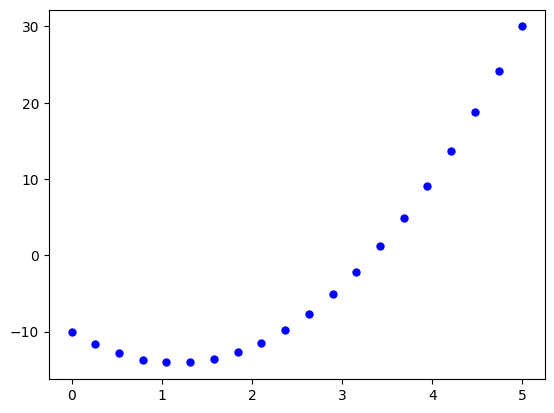

X [0.         0.26315789 0.52631579 0.78947368 1.05263158 1.31578947
 1.57894737 1.84210526 2.10526316 2.36842105 2.63157895 2.89473684
 3.15789474 3.42105263 3.68421053 3.94736842 4.21052632 4.47368421
 4.73684211 5.        ]
Y [-10.         -11.63434903 -12.8531856  -13.6565097  -14.04432133
 -14.0166205  -13.5734072  -12.71468144 -11.44044321  -9.75069252
  -7.64542936  -5.12465374  -2.18836565   1.1634349    4.93074792
   9.11357341  13.71191136  18.72576177  24.15512465  30.        ]
-------


In [82]:
x = np.linspace(0, 5, 20)
y = x**2*3 + x*-7 -10#np.sin(x)
plt.plot(x, y,'bo', markersize = 5)
plt.show()
print("X", x)
print("Y", y)
print("-------")

In [83]:
population_l = 400
genome_l = 6
mutation_rate = .03
population = Population(population_l, genome_l, mutation_rate, x, y)
print(population)

Generation: 0
Avg fitness: 3216.441748154553
Best fitness: 86.19721338091814


Generation: 1
Avg fitness: 228.41838654340347
Best fitness: 78.97274700033594
Generation: 2
Avg fitness: 127.06262288710383
Best fitness: 70.91314973601128
Generation: 3
Avg fitness: 121.43515068195542
Best fitness: 70.32227121273294
Generation: 4
Avg fitness: 96.9799338502975
Best fitness: 70.32227121273294
Generation: 5
Avg fitness: 104.9332163536394
Best fitness: 48.19661912028911
Generation: 6
Avg fitness: 94.97443569360885
Best fitness: 46.49391758511456
Generation: 7
Avg fitness: 76.02595442879553
Best fitness: 35.273306964922654
Generation: 8
Avg fitness: 88.10233509996955
Best fitness: 35.273306964922654
Generation: 9
Avg fitness: 85.65276893446215
Best fitness: 35.273306964922654
Generation: 10
Avg fitness: 82.7827051826732
Best fitness: 35.211211390933116
Generation: 11
Avg fitness: 77.78487282214326
Best fitness: 35.211211390933116
Generation: 12
Avg fitness: 71.52626161684076
Best fitness: 35.197120145484774
Generation: 13
Avg fitness: 83.02672097242822
Best fitness: 35.197

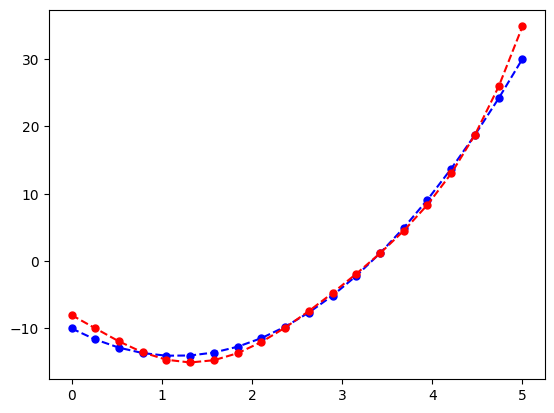

In [84]:
population.evolve_for_generations(1000)

Generation: 1
Avg fitness: 84.25283661017562
Best fitness: 33.500415385036526
Generation: 2
Avg fitness: 52.837437779920975
Best fitness: 29.170559789200542
Generation: 3
Avg fitness: 46.331726939416534
Best fitness: 28.925252012769594
Generation: 4
Avg fitness: 42.8379646097103
Best fitness: 26.79444671007453
Generation: 5
Avg fitness: 39.14420084868864
Best fitness: 26.792202030731016
Generation: 6
Avg fitness: 38.637998406564954
Best fitness: 25.48449277113495
Generation: 7
Avg fitness: 36.66870877049117
Best fitness: 19.59768610689472
Generation: 8
Avg fitness: 29.431194518337453
Best fitness: 18.553611665304647
Generation: 9
Avg fitness: 31.63581857777933
Best fitness: 17.974725206775194
Generation: 10
Avg fitness: 37.21724087038947
Best fitness: 17.974725206775194
Generation: 11
Avg fitness: 34.06384822663828
Best fitness: 17.974725206775194
Generation: 12
Avg fitness: 34.194918581494015
Best fitness: 17.95351865860985
Generation: 13
Avg fitness: 27.160318561061278
Best fitness: 

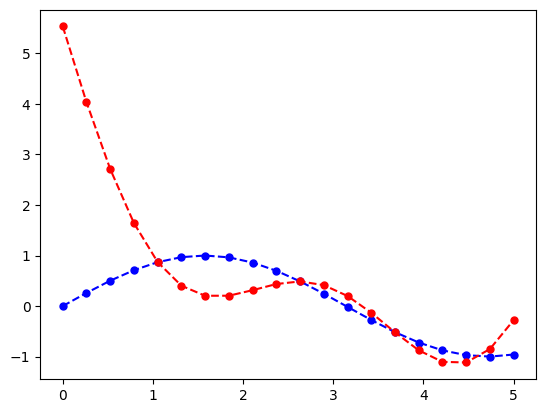

Generation: 1
Avg fitness: 119.92041343376566
Best fitness: 40.11029686584542
Generation: 2
Avg fitness: 50.21874071099458
Best fitness: 33.7587403430406
Generation: 3
Avg fitness: 46.410709147212835
Best fitness: 25.102994660933913
Generation: 4
Avg fitness: 36.74757190753602
Best fitness: 22.942640753945504
Generation: 5
Avg fitness: 37.84705549552152
Best fitness: 22.942640753945504
Generation: 6
Avg fitness: 34.383750711282545
Best fitness: 19.62928962509025
Generation: 7
Avg fitness: 34.95711276813316
Best fitness: 16.287420372013035
Generation: 8
Avg fitness: 29.841496510378793
Best fitness: 14.481740976417905
Generation: 9
Avg fitness: 21.45931528228421
Best fitness: 13.042296740224277
Generation: 10
Avg fitness: 27.34394491612808
Best fitness: 13.042296740224277
Generation: 11
Avg fitness: 27.27040651678864
Best fitness: 11.507260851864396
Generation: 12
Avg fitness: 24.94691341715593
Best fitness: 9.270225527369995
Generation: 13
Avg fitness: 19.054147225251082
Best fitness: 9

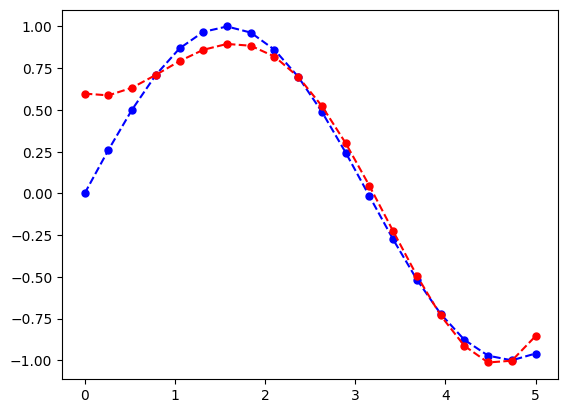

Generation: 1
Avg fitness: 75.84905654320052
Best fitness: 37.166166305438075
Generation: 2
Avg fitness: 54.46786132407699
Best fitness: 33.31515281020875
Generation: 3
Avg fitness: 49.776986256283806
Best fitness: 33.31515281020875
Generation: 4
Avg fitness: 41.340319281356045
Best fitness: 32.80747833947785
Generation: 5
Avg fitness: 43.81575982544711
Best fitness: 31.891191413819506
Generation: 6
Avg fitness: 44.23424470949441
Best fitness: 30.442558299916403
Generation: 7
Avg fitness: 45.2332466047325
Best fitness: 28.598387361012016
Generation: 8
Avg fitness: 42.047993861494696
Best fitness: 28.48338935204324
Generation: 9
Avg fitness: 42.416145178755706
Best fitness: 28.48338935204324
Generation: 10
Avg fitness: 36.69447324058895
Best fitness: 28.48338935204324
Generation: 11
Avg fitness: 35.88093574516874
Best fitness: 28.48338935204324
Generation: 12
Avg fitness: 39.88443943302122
Best fitness: 28.48338935204324
Generation: 13
Avg fitness: 38.72514362512809
Best fitness: 28.162

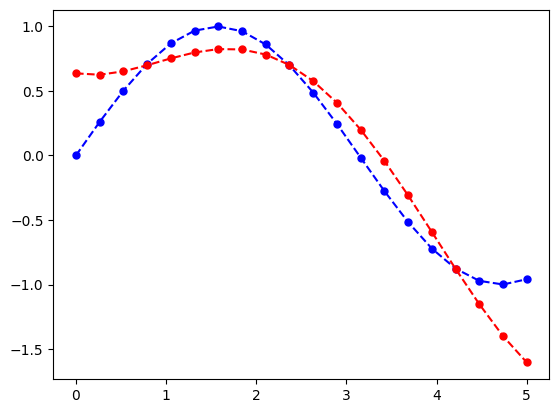

Generation: 1
Avg fitness: 68.73985207296393
Best fitness: 46.10796694967815
Generation: 2
Avg fitness: 61.46838296895128
Best fitness: 34.99621542905769
Generation: 3
Avg fitness: 56.23879677894977
Best fitness: 32.91154807896296
Generation: 4
Avg fitness: 48.200391735351374
Best fitness: 30.315956583552328
Generation: 5
Avg fitness: 42.76164726930097
Best fitness: 28.313567153447877
Generation: 6
Avg fitness: 48.91871226463985
Best fitness: 24.504358526111318
Generation: 7
Avg fitness: 43.18499812632733
Best fitness: 24.504358526111318
Generation: 8
Avg fitness: 43.2472322229588
Best fitness: 21.915252380042954
Generation: 9
Avg fitness: 33.737406079284504
Best fitness: 18.503549114699076
Generation: 10
Avg fitness: 36.78319205783791
Best fitness: 18.414806544281305
Generation: 11
Avg fitness: 35.74283739755211
Best fitness: 17.13767116228501
Generation: 12
Avg fitness: 32.3608978187456
Best fitness: 14.484854257113858
Generation: 13
Avg fitness: 31.70382090116577
Best fitness: 13.13

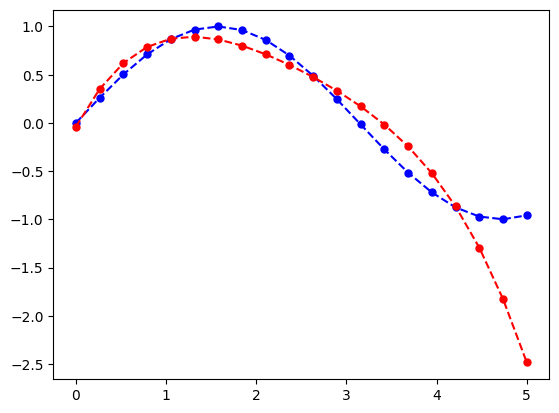

Generation: 1
Avg fitness: 73.48396676393003
Best fitness: 24.25494863654919
Generation: 2
Avg fitness: 45.22829303076973
Best fitness: 21.66407643197625
Generation: 3
Avg fitness: 29.853657282715826
Best fitness: 20.702572319997667
Generation: 4
Avg fitness: 29.28400130024827
Best fitness: 20.68613609227951
Generation: 5
Avg fitness: 30.812694101294078
Best fitness: 20.68613609227951
Generation: 6
Avg fitness: 30.501135169428434
Best fitness: 20.58504647869399
Generation: 7
Avg fitness: 27.636826189447703
Best fitness: 20.545610035525037
Generation: 8
Avg fitness: 27.021130676132508
Best fitness: 20.53802741685077
Generation: 9
Avg fitness: 29.368703709229973
Best fitness: 20.525662359103745
Generation: 10
Avg fitness: 29.687507708014277
Best fitness: 20.48718268913948
Generation: 11
Avg fitness: 27.21473489648565
Best fitness: 20.457580379294438
Generation: 12
Avg fitness: 32.840678607643504
Best fitness: 20.457580379294438
Generation: 13
Avg fitness: 28.383123192567123
Best fitness:

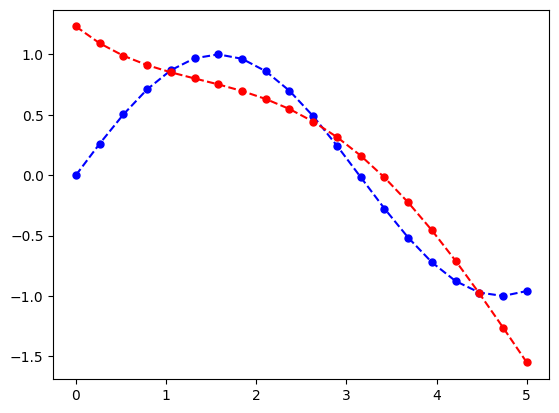

Generation: 1
Avg fitness: 58.06299862669793
Best fitness: 29.353458239476424
Generation: 2
Avg fitness: 36.79358975026614
Best fitness: 22.262824623254836
Generation: 3
Avg fitness: 30.98049643330348
Best fitness: 21.888708245999673
Generation: 4
Avg fitness: 30.005878269916312
Best fitness: 21.302690362854623
Generation: 5
Avg fitness: 31.56139404432814
Best fitness: 20.618973621633486
Generation: 6
Avg fitness: 32.241296446615586
Best fitness: 19.899651609312542
Generation: 7
Avg fitness: 29.424072242219058
Best fitness: 18.879367887558182
Generation: 8
Avg fitness: 28.29655515515493
Best fitness: 17.857670981790744
Generation: 9
Avg fitness: 30.02527359396654
Best fitness: 16.13428413489897
Generation: 10
Avg fitness: 28.67019473716362
Best fitness: 14.465187068836475
Generation: 11
Avg fitness: 28.97350292462464
Best fitness: 14.465187068836475
Generation: 12
Avg fitness: 24.44587056320536
Best fitness: 14.465187068836475
Generation: 13
Avg fitness: 30.98599753298172
Best fitness:

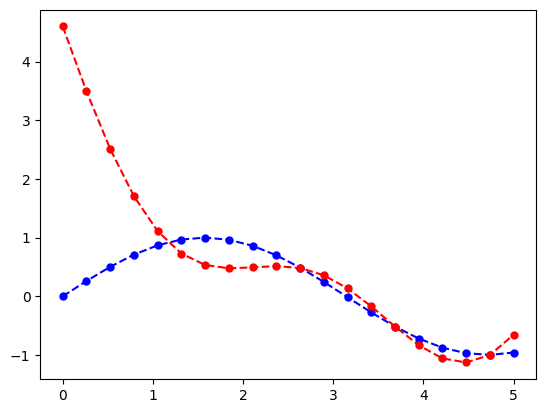

Generation: 1
Avg fitness: 56.1386557879115
Best fitness: 23.112993306853113
Generation: 2
Avg fitness: 32.5933131020205
Best fitness: 20.220582492762425
Generation: 3
Avg fitness: 26.94755230708565
Best fitness: 16.032888725792844
Generation: 4
Avg fitness: 27.1667388044672
Best fitness: 15.02978982336857
Generation: 5
Avg fitness: 24.63009209828514
Best fitness: 14.121580669402634
Generation: 6
Avg fitness: 27.487746843157716
Best fitness: 11.304965550300679
Generation: 7
Avg fitness: 20.940828697627545
Best fitness: 11.304965550300679
Generation: 8
Avg fitness: 19.71953014087434
Best fitness: 11.299170023254696
Generation: 9
Avg fitness: 18.396822042924278
Best fitness: 11.299170023254696
Generation: 10
Avg fitness: 19.753632568389374
Best fitness: 11.00788019677056
Generation: 11
Avg fitness: 20.16894206256806
Best fitness: 11.00788019677056
Generation: 12
Avg fitness: 20.25286354212891
Best fitness: 11.00788019677056
Generation: 13
Avg fitness: 19.022449457505726
Best fitness: 11.

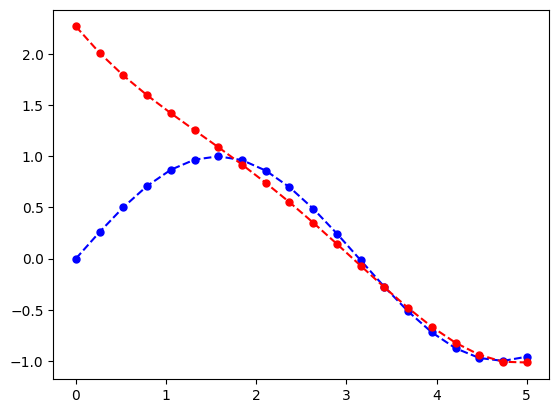

Generation: 1
Avg fitness: 169.09017363304935
Best fitness: 34.77938352592641
Generation: 2
Avg fitness: 62.05941551531717
Best fitness: 31.4509426744431
Generation: 3
Avg fitness: 50.70608402353524
Best fitness: 27.90298835160501
Generation: 4
Avg fitness: 54.709878913328666
Best fitness: 23.44874873858346
Generation: 5
Avg fitness: 47.93790605754352
Best fitness: 22.56297207451597
Generation: 6
Avg fitness: 40.73842306690732
Best fitness: 22.15068518949228
Generation: 7
Avg fitness: 46.67915698350039
Best fitness: 21.70376872001775
Generation: 8
Avg fitness: 50.80605604152483
Best fitness: 21.70376872001775
Generation: 9
Avg fitness: 45.41702282035369
Best fitness: 21.70376872001775
Generation: 10
Avg fitness: 49.09182506399799
Best fitness: 20.19650994181483
Generation: 11
Avg fitness: 49.98886776639457
Best fitness: 19.66663658609457
Generation: 12
Avg fitness: 37.96279077148411
Best fitness: 19.66663658609457
Generation: 13
Avg fitness: 41.15288407035253
Best fitness: 19.666636586

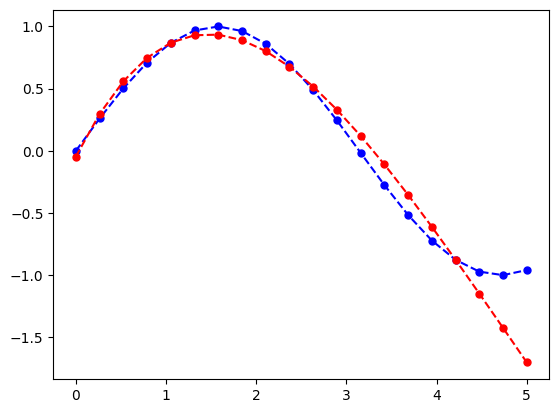

Generation: 1
Avg fitness: 109.09468673787093
Best fitness: 28.936972155377077
Generation: 2
Avg fitness: 51.212853816619464
Best fitness: 25.155877113969826
Generation: 3
Avg fitness: 37.23375954799683
Best fitness: 22.563255233024822
Generation: 4
Avg fitness: 39.63786408978963
Best fitness: 22.37474687738073
Generation: 5
Avg fitness: 47.50803494139303
Best fitness: 22.37474687738073
Generation: 6
Avg fitness: 41.28170159139208
Best fitness: 20.626243144277222
Generation: 7
Avg fitness: 40.268207116445
Best fitness: 20.542287586561468
Generation: 8
Avg fitness: 33.82553510772899
Best fitness: 19.981348273377616
Generation: 9
Avg fitness: 34.69160937984361
Best fitness: 17.722880451177005
Generation: 10
Avg fitness: 36.07241883124596
Best fitness: 17.558645016502695
Generation: 11
Avg fitness: 43.12789877538008
Best fitness: 17.09450804117188
Generation: 12
Avg fitness: 36.44461840169852
Best fitness: 17.09450804117188
Generation: 13
Avg fitness: 34.36666843520017
Best fitness: 17.09

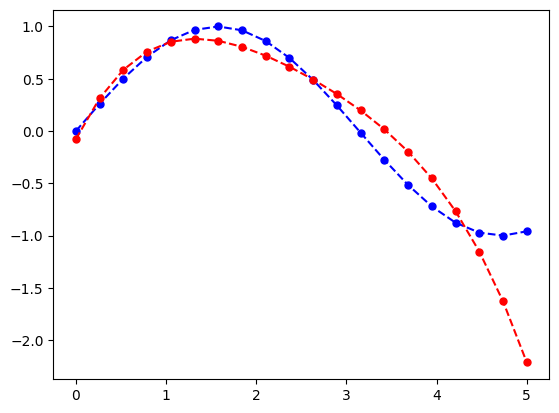

Generation: 1
Avg fitness: 67.83592153257162
Best fitness: 25.78590952078423
Generation: 2
Avg fitness: 34.94569551815528
Best fitness: 11.513456459759995
Generation: 3
Avg fitness: 15.260846455868148
Best fitness: 10.493987733370352
Generation: 4
Avg fitness: 15.836740207853898
Best fitness: 7.706945242333311
Generation: 5
Avg fitness: 12.412204237369751
Best fitness: 4.95012916946082
Generation: 6
Avg fitness: 11.012091158822036
Best fitness: 4.351951726971222
Generation: 7
Avg fitness: 10.322951415951216
Best fitness: 4.351951726971222
Generation: 8
Avg fitness: 10.050813818439547
Best fitness: 4.351951726971222
Generation: 9
Avg fitness: 8.594715390656795
Best fitness: 4.0256640393328755
Generation: 10
Avg fitness: 10.11855286298492
Best fitness: 3.965021743000333
Generation: 11
Avg fitness: 9.011748968799093
Best fitness: 3.7089469378813953
Generation: 12
Avg fitness: 8.621272678074696
Best fitness: 3.7089469378813953
Generation: 13
Avg fitness: 8.966627983803013
Best fitness: 3.7

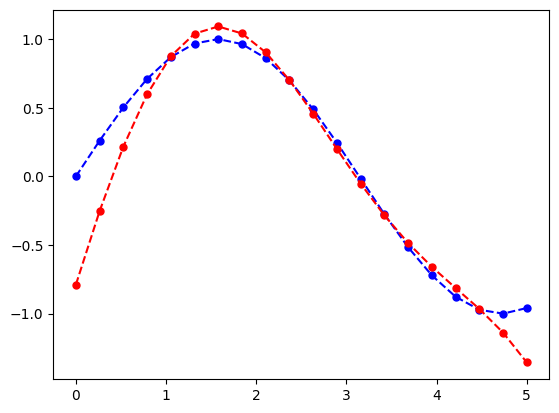

Generation: 1
Avg fitness: 123.07683802443471
Best fitness: 42.48204754124366
Generation: 2
Avg fitness: 67.7879042473919
Best fitness: 25.817613087776508
Generation: 3
Avg fitness: 50.613457131237794
Best fitness: 24.850104943010297
Generation: 4
Avg fitness: 39.62926268899088
Best fitness: 22.73647630167492
Generation: 5
Avg fitness: 36.85204038630649
Best fitness: 21.34528256676439
Generation: 6
Avg fitness: 38.81385992845026
Best fitness: 18.202555149958858
Generation: 7
Avg fitness: 35.73431749723173
Best fitness: 17.614085204369374
Generation: 8
Avg fitness: 34.44576754263376
Best fitness: 17.21556097381667
Generation: 9
Avg fitness: 29.881288193145615
Best fitness: 14.406161888909395
Generation: 10
Avg fitness: 34.332205153247216
Best fitness: 14.406161888909395
Generation: 11
Avg fitness: 29.68232123174062
Best fitness: 14.406161888909395
Generation: 12
Avg fitness: 37.07375348278733
Best fitness: 14.406161888909395
Generation: 13
Avg fitness: 29.17528450021508
Best fitness: 14

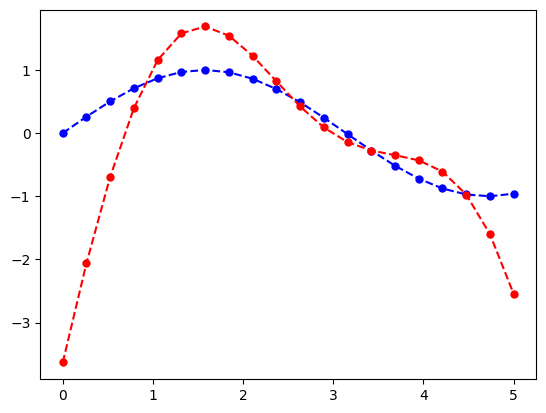

Generation: 1
Avg fitness: 53.31907957727374
Best fitness: 28.482886619420228
Generation: 2
Avg fitness: 27.72030642851202
Best fitness: 10.323986025508816
Generation: 3
Avg fitness: 11.09508310236006
Best fitness: 7.175925530522348
Generation: 4
Avg fitness: 8.34173445795481
Best fitness: 6.955605509981542
Generation: 5
Avg fitness: 7.893246914803668
Best fitness: 6.66173878694042
Generation: 6
Avg fitness: 7.538966367490991
Best fitness: 6.177651113276131
Generation: 7
Avg fitness: 7.591824685228918
Best fitness: 6.147568928851229
Generation: 8
Avg fitness: 6.992283351707942
Best fitness: 5.689471826418638
Generation: 9
Avg fitness: 6.685128909487646
Best fitness: 4.914177946816986
Generation: 10
Avg fitness: 5.734652474202472
Best fitness: 4.402302053166843
Generation: 11
Avg fitness: 5.433598745837714
Best fitness: 3.0154455474272717
Generation: 12
Avg fitness: 4.857630918023884
Best fitness: 2.7548831852766478
Generation: 13
Avg fitness: 4.179598262255635
Best fitness: 2.393941221

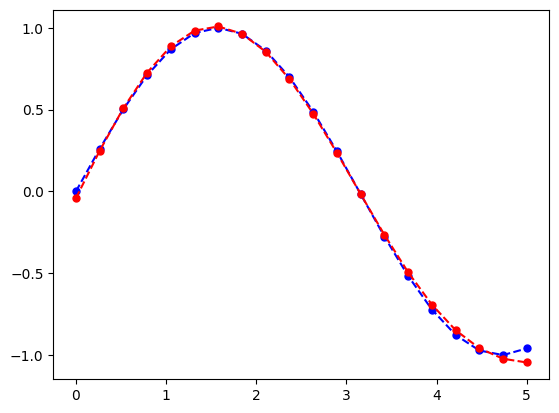

Generation: 1
Avg fitness: 69.1448541771505
Best fitness: 42.51880981116935
Generation: 2
Avg fitness: 49.948108350735744
Best fitness: 29.819775089887145
Generation: 3
Avg fitness: 33.75913459048497
Best fitness: 19.698769589287178
Generation: 4
Avg fitness: 34.75534116099024
Best fitness: 17.779326205671
Generation: 5
Avg fitness: 27.47146040385561
Best fitness: 14.319797530217242
Generation: 6
Avg fitness: 24.862935395604687
Best fitness: 12.030740311923779
Generation: 7
Avg fitness: 24.30933703511346
Best fitness: 11.405847521873264
Generation: 8
Avg fitness: 21.64205701306023
Best fitness: 9.843992137549193
Generation: 9
Avg fitness: 19.619047758462724
Best fitness: 9.843992137549193
Generation: 10
Avg fitness: 23.766311807946575
Best fitness: 9.833788964512065
Generation: 11
Avg fitness: 23.279771650874878
Best fitness: 9.829251315236975
Generation: 12
Avg fitness: 19.20637887829265
Best fitness: 9.829251315236975
Generation: 13
Avg fitness: 20.7988154565938
Best fitness: 8.43692

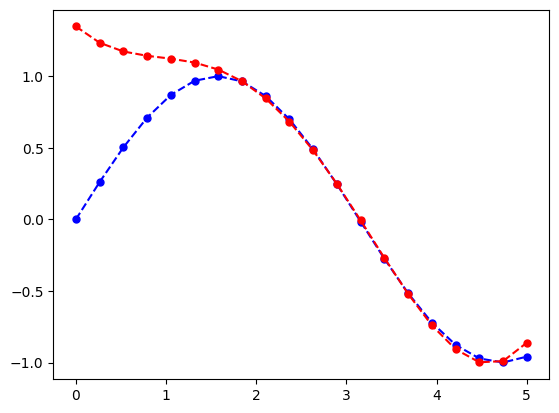

Generation: 1
Avg fitness: 72.26881168430583
Best fitness: 42.865334757363605
Generation: 2
Avg fitness: 49.288646085629104
Best fitness: 32.324136064232405
Generation: 3
Avg fitness: 35.81604319850474
Best fitness: 29.860877588710462
Generation: 4
Avg fitness: 33.968780052028286
Best fitness: 28.980196311046047
Generation: 5
Avg fitness: 33.87436611328705
Best fitness: 28.139573660455042
Generation: 6
Avg fitness: 32.776774781161684
Best fitness: 27.562011449085315
Generation: 7
Avg fitness: 33.58249238644275
Best fitness: 26.484174260699042
Generation: 8
Avg fitness: 33.61215058311191
Best fitness: 23.66218009052777
Generation: 9
Avg fitness: 31.04234194435365
Best fitness: 20.84230077508417
Generation: 10
Avg fitness: 27.54957462518246
Best fitness: 19.530529319325947
Generation: 11
Avg fitness: 24.914826678752043
Best fitness: 18.774392128972107
Generation: 12
Avg fitness: 24.250601356611146
Best fitness: 16.817437149890285
Generation: 13
Avg fitness: 22.255562509281223
Best fitnes

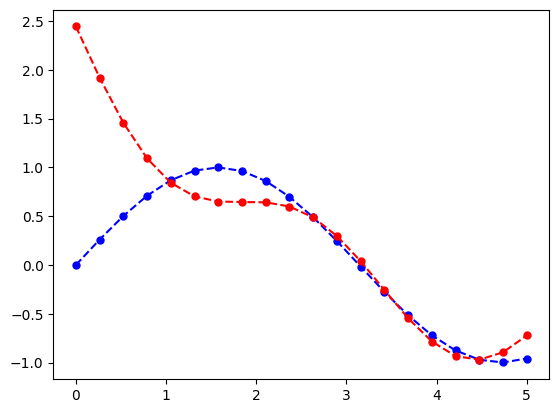

Generation: 1
Avg fitness: 114.53545323440953
Best fitness: 52.70952043715349
Generation: 2
Avg fitness: 80.02516901435708
Best fitness: 40.00344430220866
Generation: 3
Avg fitness: 65.07291412442622
Best fitness: 30.11184923694506
Generation: 4
Avg fitness: 48.8563252860843
Best fitness: 29.574729045149624
Generation: 5
Avg fitness: 51.50297811483188
Best fitness: 22.79545653161943
Generation: 6
Avg fitness: 47.164969191959806
Best fitness: 22.79545653161943
Generation: 7
Avg fitness: 43.702749123299924
Best fitness: 21.19286403368048
Generation: 8
Avg fitness: 40.63426774453379
Best fitness: 19.87013794307854
Generation: 9
Avg fitness: 44.714360083648174
Best fitness: 19.87013794307854
Generation: 10
Avg fitness: 31.258652691252145
Best fitness: 19.87013794307854
Generation: 11
Avg fitness: 44.939152895174786
Best fitness: 19.87013794307854
Generation: 12
Avg fitness: 31.59905062470277
Best fitness: 17.525267167118788
Generation: 13
Avg fitness: 33.493938594671114
Best fitness: 17.52

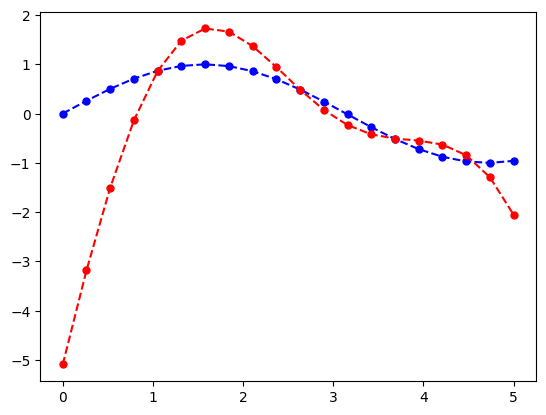

Generation: 1
Avg fitness: 94.50741621280258
Best fitness: 32.15424897151507
Generation: 2
Avg fitness: 51.55092181316698
Best fitness: 29.077840429615552
Generation: 3
Avg fitness: 45.501270125313525
Best fitness: 28.787418829674994
Generation: 4
Avg fitness: 42.535086806729915
Best fitness: 27.413678132893462
Generation: 5
Avg fitness: 45.126217421536445
Best fitness: 22.669085396718962
Generation: 6
Avg fitness: 39.91452096638103
Best fitness: 22.669085396718962
Generation: 7
Avg fitness: 43.087109480944434
Best fitness: 21.713171208526077
Generation: 8
Avg fitness: 32.585170794525354
Best fitness: 21.09607005206451
Generation: 9
Avg fitness: 33.13686312709385
Best fitness: 20.945340810908903
Generation: 10
Avg fitness: 35.19589139215422
Best fitness: 20.945340810908903
Generation: 11
Avg fitness: 37.575209069310624
Best fitness: 15.396939769346092
Generation: 12
Avg fitness: 36.606235664811244
Best fitness: 14.774031782420199
Generation: 13
Avg fitness: 36.16801955991085
Best fitne

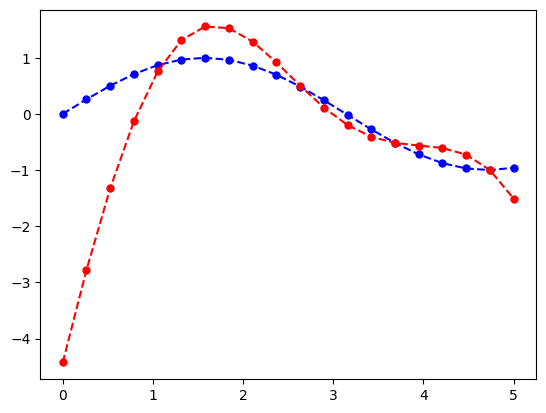

Generation: 1
Avg fitness: 115.89311353414942
Best fitness: 31.936571969489624
Generation: 2
Avg fitness: 39.45673060845788
Best fitness: 26.76234642496071
Generation: 3
Avg fitness: 36.02817621980097
Best fitness: 25.65702311074856
Generation: 4
Avg fitness: 33.39015422964135
Best fitness: 24.839149064084772
Generation: 5
Avg fitness: 29.99452250612658
Best fitness: 17.987832926731503
Generation: 6
Avg fitness: 29.58145353562934
Best fitness: 13.514996800052584
Generation: 7
Avg fitness: 27.809726753647283
Best fitness: 13.34355260443869
Generation: 8
Avg fitness: 21.554495008341704
Best fitness: 11.237619957543318
Generation: 9
Avg fitness: 23.550438820472227
Best fitness: 10.943030699728059
Generation: 10
Avg fitness: 21.19171376808215
Best fitness: 10.943030699728059
Generation: 11
Avg fitness: 20.952214308210717
Best fitness: 10.943030699728059
Generation: 12
Avg fitness: 23.32636952305476
Best fitness: 10.891214090313344
Generation: 13
Avg fitness: 20.938713050716746
Best fitness

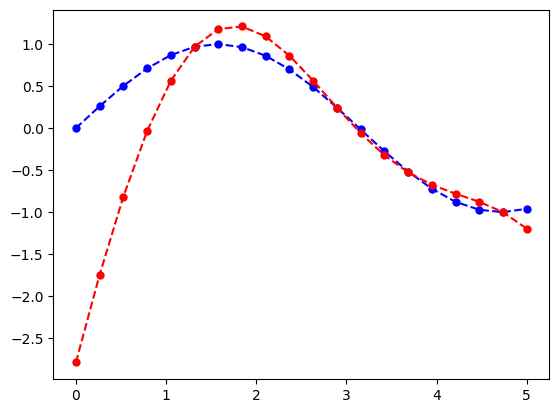

Generation: 1
Avg fitness: 231.82679706262283
Best fitness: 65.11434815421453
Generation: 2
Avg fitness: 81.77485657078805
Best fitness: 39.01266451011125
Generation: 3
Avg fitness: 75.11832350027066
Best fitness: 39.01266451011125
Generation: 4
Avg fitness: 62.368366226354745
Best fitness: 35.180014280238694
Generation: 5
Avg fitness: 50.98983697415948
Best fitness: 35.180014280238694
Generation: 6
Avg fitness: 57.43252061614058
Best fitness: 32.911706741569986
Generation: 7
Avg fitness: 59.193392004366636
Best fitness: 32.911706741569986
Generation: 8
Avg fitness: 67.63301747267943
Best fitness: 32.911706741569986
Generation: 9
Avg fitness: 58.462888124461955
Best fitness: 32.911706741569986
Generation: 10
Avg fitness: 69.51926541256596
Best fitness: 32.911706741569986
Generation: 11
Avg fitness: 57.91054192854919
Best fitness: 32.911706741569986
Generation: 12
Avg fitness: 52.29716628237715
Best fitness: 32.900770571119885
Generation: 13
Avg fitness: 58.423890268584245
Best fitness:

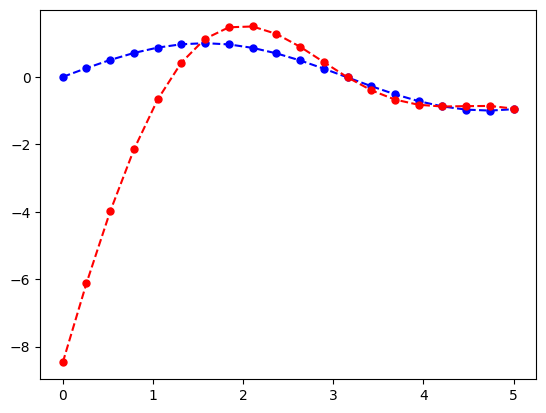

Generation: 1
Avg fitness: 121.27911214941555
Best fitness: 53.62341205989673
Generation: 2
Avg fitness: 90.33563520434387
Best fitness: 47.97185383916817
Generation: 3
Avg fitness: 75.84308120142887
Best fitness: 47.97185383916817
Generation: 4
Avg fitness: 81.40556259325442
Best fitness: 43.39553531501592
Generation: 5
Avg fitness: 61.165023827153824
Best fitness: 42.465522073696555
Generation: 6
Avg fitness: 82.73092379084235
Best fitness: 42.45457857748296
Generation: 7
Avg fitness: 64.49047357758596
Best fitness: 40.457732459952084
Generation: 8
Avg fitness: 83.14753854438617
Best fitness: 38.62126153864211
Generation: 9
Avg fitness: 75.51132960452338
Best fitness: 38.62126153864211
Generation: 10
Avg fitness: 88.51178530197045
Best fitness: 38.62126153864211
Generation: 11
Avg fitness: 76.21065371766079
Best fitness: 38.62126153864211
Generation: 12
Avg fitness: 78.1369883831052
Best fitness: 38.62126153864211
Generation: 13
Avg fitness: 73.46310875288512
Best fitness: 38.6212615

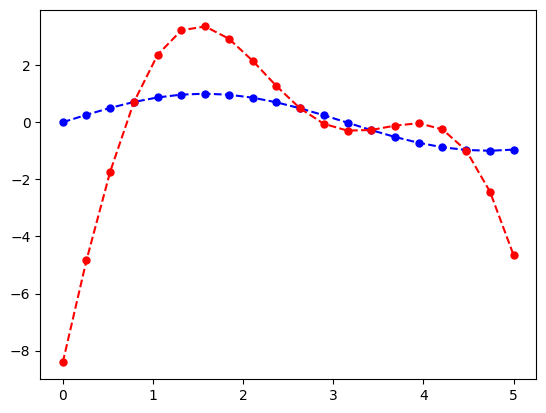

Generation: 1
Avg fitness: 122.81114685708734
Best fitness: 31.918432415857335
Generation: 2
Avg fitness: 48.34033153776221
Best fitness: 27.49403174305699
Generation: 3
Avg fitness: 46.70932534690749
Best fitness: 27.145591682802653
Generation: 4
Avg fitness: 48.598089383147354
Best fitness: 23.757193518998477
Generation: 5
Avg fitness: 39.539965854796854
Best fitness: 22.152330300125843
Generation: 6
Avg fitness: 37.17326347395979
Best fitness: 22.152330300125843
Generation: 7
Avg fitness: 33.76991173709496
Best fitness: 22.068466545107626
Generation: 8
Avg fitness: 39.34719531720627
Best fitness: 22.068466545107626
Generation: 9
Avg fitness: 37.2347314563381
Best fitness: 22.068466545107626
Generation: 10
Avg fitness: 41.244579107868795
Best fitness: 22.068466545107626
Generation: 11
Avg fitness: 41.03225129374904
Best fitness: 22.068466545107626
Generation: 12
Avg fitness: 42.47357383843915
Best fitness: 21.644656423746067
Generation: 13
Avg fitness: 43.68322158227541
Best fitness:

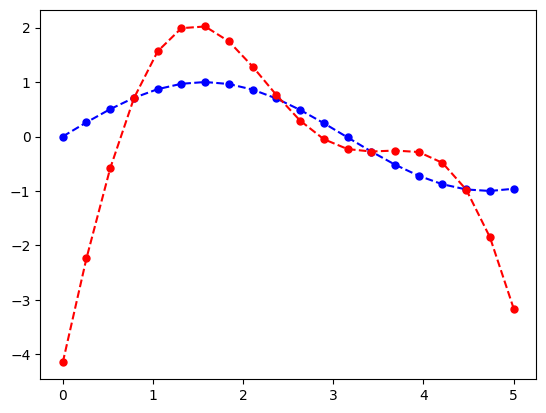

Generation: 1
Avg fitness: 67.58222757265908
Best fitness: 25.325990209153375
Generation: 2
Avg fitness: 35.88589924189198
Best fitness: 22.713368361866944
Generation: 3
Avg fitness: 28.291158526021153
Best fitness: 21.67609448592511
Generation: 4
Avg fitness: 25.854966364798766
Best fitness: 15.025064239914848
Generation: 5
Avg fitness: 22.505199850737952
Best fitness: 7.4815452275408
Generation: 6
Avg fitness: 15.480419357999375
Best fitness: 5.638298843545621
Generation: 7
Avg fitness: 11.997193974730894
Best fitness: 5.481483495001523
Generation: 8
Avg fitness: 10.04203201283582
Best fitness: 5.481483495001523
Generation: 9
Avg fitness: 10.511366920746447
Best fitness: 5.365765313699387
Generation: 10
Avg fitness: 11.094419074003133
Best fitness: 5.2183515269263845
Generation: 11
Avg fitness: 9.061898070761488
Best fitness: 5.123596243641078
Generation: 12
Avg fitness: 9.547487278099654
Best fitness: 5.123596243641078
Generation: 13
Avg fitness: 10.41582934417847
Best fitness: 5.12

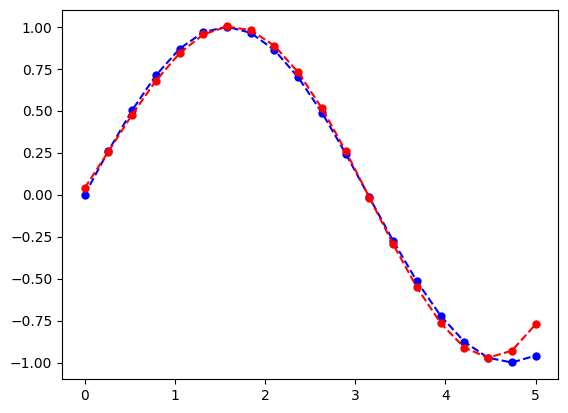

Generation: 1
Avg fitness: 114.36116706821362
Best fitness: 42.21537542490049
Generation: 2
Avg fitness: 86.30963506525012
Best fitness: 36.61828755927387
Generation: 3
Avg fitness: 77.60815310040672
Best fitness: 32.001087228105014
Generation: 4
Avg fitness: 71.8395182833219
Best fitness: 32.001087228105014
Generation: 5
Avg fitness: 55.43389520808329
Best fitness: 24.528432333832935
Generation: 6
Avg fitness: 52.09819605896015
Best fitness: 24.528432333832935
Generation: 7
Avg fitness: 48.21311824479653
Best fitness: 23.515660636563645
Generation: 8
Avg fitness: 55.26230222742762
Best fitness: 23.515660636563645
Generation: 9
Avg fitness: 66.43650969999004
Best fitness: 23.200223695872698
Generation: 10
Avg fitness: 43.655770251899256
Best fitness: 23.200223695872698
Generation: 11
Avg fitness: 48.06319107031616
Best fitness: 23.200223695872698
Generation: 12
Avg fitness: 47.53158375890552
Best fitness: 23.200223695872698
Generation: 13
Avg fitness: 53.13091281172872
Best fitness: 23

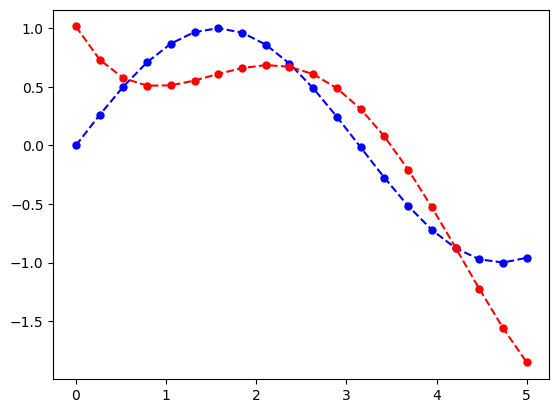

Generation: 1
Avg fitness: 107.7546519836019
Best fitness: 41.019257864230106
Generation: 2
Avg fitness: 67.04353552046742
Best fitness: 41.019257864230106
Generation: 3
Avg fitness: 62.0834528567185
Best fitness: 40.928896229910904
Generation: 4
Avg fitness: 61.59502750751264
Best fitness: 40.928896229910904
Generation: 5
Avg fitness: 66.82456637075911
Best fitness: 40.379367922155716
Generation: 6
Avg fitness: 70.19266648649747
Best fitness: 40.379367922155716
Generation: 7
Avg fitness: 62.12238158245587
Best fitness: 40.262007311708174
Generation: 8
Avg fitness: 70.52079577855197
Best fitness: 40.262007311708174
Generation: 9
Avg fitness: 61.406756009666395
Best fitness: 40.262007311708174
Generation: 10
Avg fitness: 61.95686026835271
Best fitness: 40.262007311708174
Generation: 11
Avg fitness: 74.03396557704689
Best fitness: 40.262007311708174
Generation: 12
Avg fitness: 70.43141882546496
Best fitness: 40.262007311708174
Generation: 13
Avg fitness: 81.41740930773406
Best fitness: 4

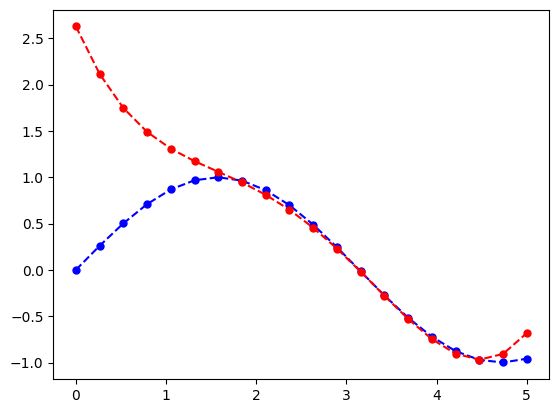

Generation: 1
Avg fitness: 87.72251655937431
Best fitness: 12.562739573461666
Generation: 2
Avg fitness: 17.120220381649133
Best fitness: 12.21112665353123
Generation: 3
Avg fitness: 15.743113369016694
Best fitness: 11.153532724207242
Generation: 4
Avg fitness: 16.62475237303295
Best fitness: 7.638317273046001
Generation: 5
Avg fitness: 11.156268379318297
Best fitness: 7.183327624297668
Generation: 6
Avg fitness: 12.433026571401783
Best fitness: 5.756566041779394
Generation: 7
Avg fitness: 10.75607823617431
Best fitness: 5.557876768511598
Generation: 8
Avg fitness: 10.454699777179588
Best fitness: 5.119761944618704
Generation: 9
Avg fitness: 11.080223378758319
Best fitness: 5.119761944618704
Generation: 10
Avg fitness: 8.998066544585512
Best fitness: 4.965224416652095
Generation: 11
Avg fitness: 9.822543146868547
Best fitness: 4.8544816776885575
Generation: 12
Avg fitness: 8.8730123998689
Best fitness: 4.8544816776885575
Generation: 13
Avg fitness: 8.392135642974866
Best fitness: 4.854

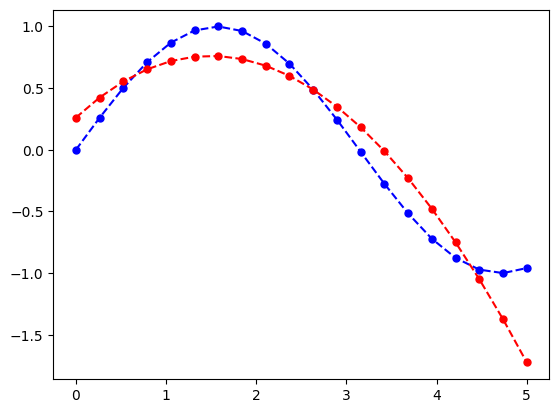

Generation: 1
Avg fitness: 77.40789324589753
Best fitness: 40.07811769988889
Generation: 2
Avg fitness: 62.52780273682665
Best fitness: 40.07811769988889
Generation: 3
Avg fitness: 61.218748790050405
Best fitness: 38.427297299663735
Generation: 4
Avg fitness: 53.93636940076534
Best fitness: 37.23501014481628
Generation: 5
Avg fitness: 60.53238221892897
Best fitness: 35.95333651149847
Generation: 6
Avg fitness: 61.67006001543388
Best fitness: 31.733515908974937
Generation: 7
Avg fitness: 55.70256755354024
Best fitness: 29.14608779922488
Generation: 8
Avg fitness: 59.803180105464655
Best fitness: 23.79946344520623
Generation: 9
Avg fitness: 49.907358273810075
Best fitness: 23.79946344520623
Generation: 10
Avg fitness: 47.880968355251355
Best fitness: 23.713071276277503
Generation: 11
Avg fitness: 44.097880227851036
Best fitness: 23.713071276277503
Generation: 12
Avg fitness: 43.085011905905795
Best fitness: 23.713071276277503
Generation: 13
Avg fitness: 45.68918631605093
Best fitness: 22

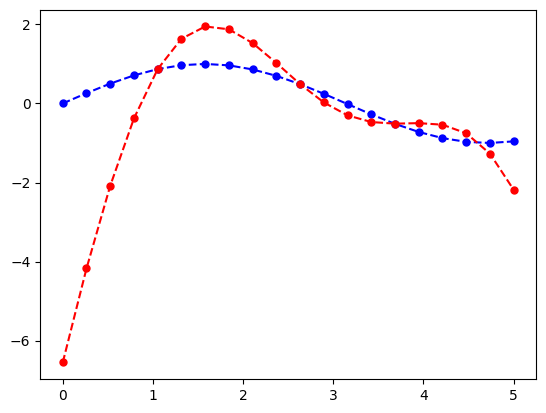

Generation: 1
Avg fitness: 97.98244676245328
Best fitness: 17.852443194845726
Generation: 2
Avg fitness: 21.459972046409572
Best fitness: 14.171979697666867
Generation: 3
Avg fitness: 17.161410352479564
Best fitness: 13.863857261684748
Generation: 4
Avg fitness: 17.717018536256994
Best fitness: 13.602119162237708
Generation: 5
Avg fitness: 19.44113531839649
Best fitness: 13.123864582391505
Generation: 6
Avg fitness: 18.163311385642473
Best fitness: 12.853238161233405
Generation: 7
Avg fitness: 17.665787807236594
Best fitness: 12.853238161233405
Generation: 8
Avg fitness: 15.134307392631378
Best fitness: 12.834300910780254
Generation: 9
Avg fitness: 15.80113638144995
Best fitness: 12.73945029720346
Generation: 10
Avg fitness: 16.988915355239488
Best fitness: 12.186507632474921
Generation: 11
Avg fitness: 15.659920747661303
Best fitness: 12.030536447544467
Generation: 12
Avg fitness: 15.269288909285073
Best fitness: 11.999001877831631
Generation: 13
Avg fitness: 14.87636503774102
Best fi

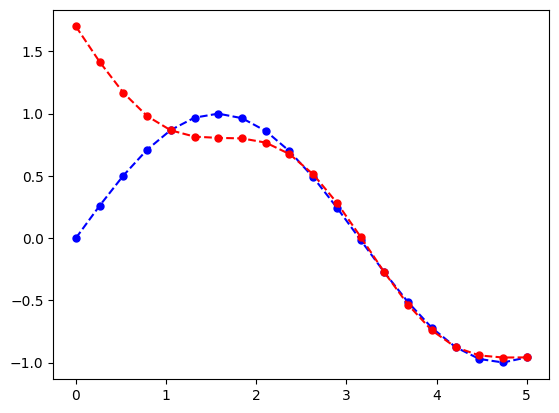

Generation: 1
Avg fitness: 133.64275284682978
Best fitness: 37.20165716042088
Generation: 2
Avg fitness: 38.70776877374987
Best fitness: 10.655818138343523
Generation: 3
Avg fitness: 15.792830209843725
Best fitness: 9.052069850077755
Generation: 4
Avg fitness: 10.609013723257297
Best fitness: 8.695658780078334
Generation: 5
Avg fitness: 10.83092087858663
Best fitness: 6.8108125188520745
Generation: 6
Avg fitness: 9.031252281164047
Best fitness: 5.416277313214618
Generation: 7
Avg fitness: 6.872584536021718
Best fitness: 4.334392521587875
Generation: 8
Avg fitness: 7.924724108091112
Best fitness: 3.425560359000849
Generation: 9
Avg fitness: 6.950007446673773
Best fitness: 2.286813711244121
Generation: 10
Avg fitness: 5.152471216589237
Best fitness: 2.286813711244121
Generation: 11
Avg fitness: 6.178626592259634
Best fitness: 2.042639180638507
Generation: 12
Avg fitness: 4.48577410666026
Best fitness: 1.355471042954166
Generation: 13
Avg fitness: 4.895241305935071
Best fitness: 1.3438245

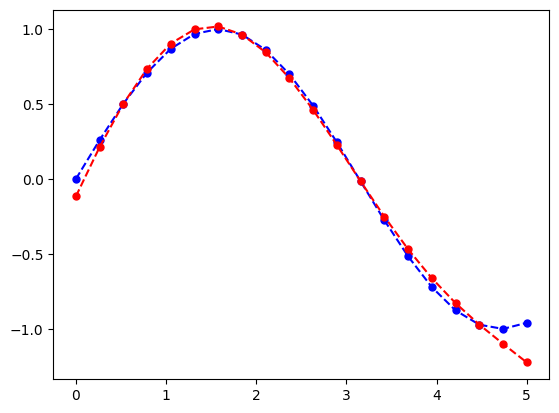

Generation: 1
Avg fitness: 68.16170890775037
Best fitness: 26.870080221942573
Generation: 2
Avg fitness: 57.013636983565114
Best fitness: 17.990799463023652
Generation: 3
Avg fitness: 40.98254638083263
Best fitness: 13.793236114795084
Generation: 4
Avg fitness: 35.513208158863115
Best fitness: 13.793236114795084
Generation: 5
Avg fitness: 27.415772581813858
Best fitness: 13.706135822552682
Generation: 6
Avg fitness: 34.498311694879646
Best fitness: 13.706135822552682
Generation: 7
Avg fitness: 25.442911605174963
Best fitness: 13.437662373686049
Generation: 8
Avg fitness: 23.861991595941117
Best fitness: 13.437662373686049
Generation: 9
Avg fitness: 32.28305474790315
Best fitness: 13.29200021398783
Generation: 10
Avg fitness: 24.2481418462965
Best fitness: 13.29200021398783
Generation: 11
Avg fitness: 33.301479676692225
Best fitness: 13.29200021398783
Generation: 12
Avg fitness: 28.912073616238636
Best fitness: 13.29200021398783
Generation: 13
Avg fitness: 29.88757945457283
Best fitness

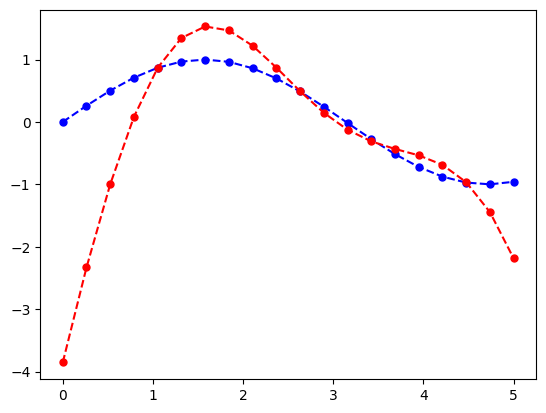

Generation: 1
Avg fitness: 97.14966994694565
Best fitness: 18.05111107013987
Generation: 2
Avg fitness: 40.90303792844639
Best fitness: 18.05111107013987
Generation: 3
Avg fitness: 22.2705895204341
Best fitness: 17.68027178731068
Generation: 4
Avg fitness: 23.209403515832317
Best fitness: 16.84804641520428
Generation: 5
Avg fitness: 20.21447677560856
Best fitness: 16.74986038420228
Generation: 6
Avg fitness: 21.05700303632388
Best fitness: 12.191941548449316
Generation: 7
Avg fitness: 17.64030762770105
Best fitness: 10.099440444129332
Generation: 8
Avg fitness: 14.303968184920395
Best fitness: 9.41452938268574
Generation: 9
Avg fitness: 14.910487003869285
Best fitness: 9.223884147529834
Generation: 10
Avg fitness: 13.758455264911571
Best fitness: 8.891030964623672
Generation: 11
Avg fitness: 13.843695210931845
Best fitness: 7.90234856188334
Generation: 12
Avg fitness: 13.314502144270621
Best fitness: 6.965075056781776
Generation: 13
Avg fitness: 13.689988309497094
Best fitness: 6.96507

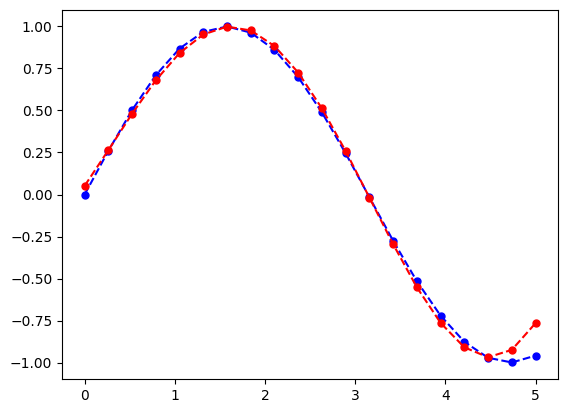

Generation: 1
Avg fitness: 72.32363907545954
Best fitness: 20.391982225283982
Generation: 2
Avg fitness: 30.284908010851296
Best fitness: 11.438542500341915
Generation: 3
Avg fitness: 16.706919272964058
Best fitness: 9.100484697826507
Generation: 4
Avg fitness: 16.325699062714254
Best fitness: 7.5524183678501755
Generation: 5
Avg fitness: 12.216595259202265
Best fitness: 6.971398159136393
Generation: 6
Avg fitness: 11.97756281448303
Best fitness: 6.971398159136393
Generation: 7
Avg fitness: 10.991403749552465
Best fitness: 5.901450445606099
Generation: 8
Avg fitness: 10.659589347187943
Best fitness: 5.562642009499785
Generation: 9
Avg fitness: 9.85521439698546
Best fitness: 5.562642009499785
Generation: 10
Avg fitness: 11.292997109774118
Best fitness: 5.562642009499785
Generation: 11
Avg fitness: 10.435571847051685
Best fitness: 5.348722343887115
Generation: 12
Avg fitness: 9.706943844101913
Best fitness: 5.348722343887115
Generation: 13
Avg fitness: 9.456923816719131
Best fitness: 5.3

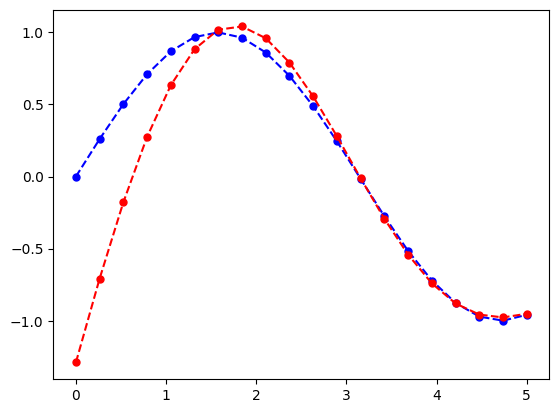

Generation: 1
Avg fitness: 107.21096409536473
Best fitness: 26.747413459251316
Generation: 2
Avg fitness: 41.01568372326074
Best fitness: 13.484378584694353
Generation: 3
Avg fitness: 25.421420672191505
Best fitness: 9.55976982544736
Generation: 4
Avg fitness: 16.000445260712098
Best fitness: 8.30389993768985
Generation: 5
Avg fitness: 15.15543716365268
Best fitness: 8.30389993768985
Generation: 6
Avg fitness: 13.35663540696875
Best fitness: 8.30389993768985
Generation: 7
Avg fitness: 14.837126870613734
Best fitness: 7.2566213230628165
Generation: 8
Avg fitness: 14.501806208082128
Best fitness: 7.152629770440808
Generation: 9
Avg fitness: 15.759207854261481
Best fitness: 7.152629770440808
Generation: 10
Avg fitness: 14.22712231295261
Best fitness: 7.152629770440808
Generation: 11
Avg fitness: 13.998797930561928
Best fitness: 7.017474061606827
Generation: 12
Avg fitness: 12.84568052461751
Best fitness: 6.241930731049976
Generation: 13
Avg fitness: 10.488315863299032
Best fitness: 6.2419

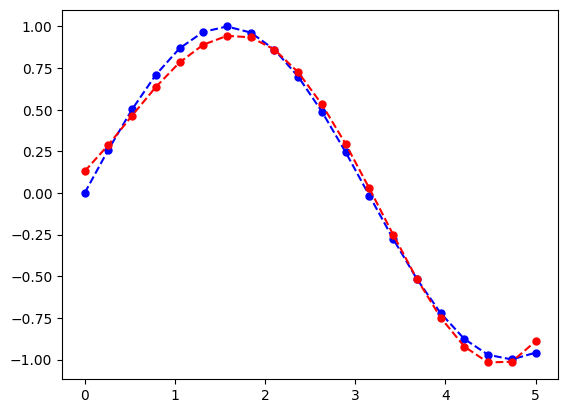

Generation: 1
Avg fitness: 203.8509255164875
Best fitness: 45.876528715128885
Generation: 2
Avg fitness: 64.88250215830313
Best fitness: 43.45526800842926
Generation: 3
Avg fitness: 56.117048770863974
Best fitness: 41.41974903959938
Generation: 4
Avg fitness: 66.10582201000899
Best fitness: 41.41481965690965
Generation: 5
Avg fitness: 64.98978246002913
Best fitness: 37.06941341982999
Generation: 6
Avg fitness: 64.7556067211234
Best fitness: 31.535911684253865
Generation: 7
Avg fitness: 50.71792545972237
Best fitness: 29.326103358976756
Generation: 8
Avg fitness: 60.539743329808225
Best fitness: 29.106723196487295
Generation: 9
Avg fitness: 60.68264549514444
Best fitness: 28.784649806551013
Generation: 10
Avg fitness: 51.010924646656036
Best fitness: 27.892564922823166
Generation: 11
Avg fitness: 46.60853973488467
Best fitness: 26.793113982371285
Generation: 12
Avg fitness: 53.995432074850534
Best fitness: 26.664078842917213
Generation: 13
Avg fitness: 46.74478873126563
Best fitness: 24

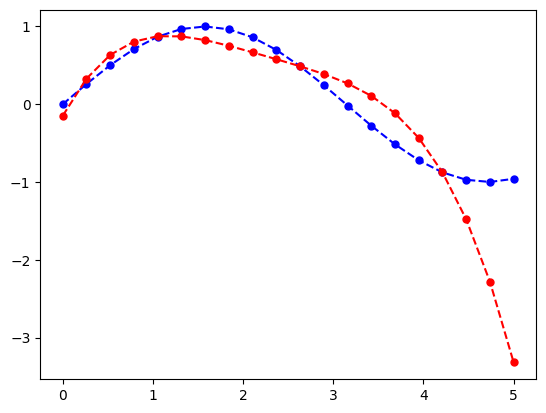

Generation: 1
Avg fitness: 73.04172290844006
Best fitness: 36.76759587591296
Generation: 2
Avg fitness: 60.42925821200732
Best fitness: 32.06993245845275
Generation: 3
Avg fitness: 45.35768458857
Best fitness: 31.6962967600997
Generation: 4
Avg fitness: 39.97012949579132
Best fitness: 28.560046949323567
Generation: 5
Avg fitness: 39.944109172873816
Best fitness: 16.073681795336398
Generation: 6
Avg fitness: 28.068321761504663
Best fitness: 9.148938243913552
Generation: 7
Avg fitness: 19.948875814883067
Best fitness: 8.139465390505983
Generation: 8
Avg fitness: 18.1627564066504
Best fitness: 8.139465390505983
Generation: 9
Avg fitness: 21.534770482961154
Best fitness: 8.139465390505983
Generation: 10
Avg fitness: 17.987144262219246
Best fitness: 8.139465390505983
Generation: 11
Avg fitness: 19.136698544365203
Best fitness: 8.139465390505983
Generation: 12
Avg fitness: 21.643174203399436
Best fitness: 7.7602044629433085
Generation: 13
Avg fitness: 20.16094443949438
Best fitness: 7.760204

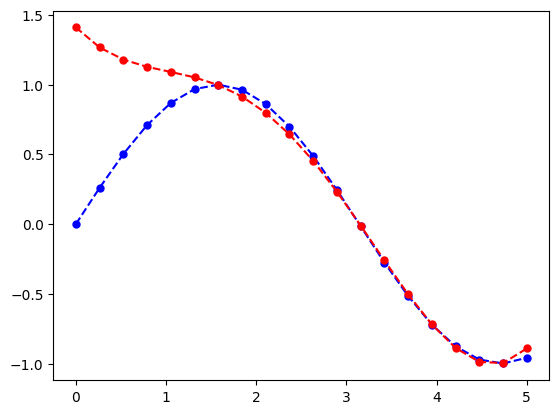

Generation: 1
Avg fitness: 102.42891444231591
Best fitness: 28.812297433776486
Generation: 2
Avg fitness: 33.29609233867577
Best fitness: 23.6681097649236
Generation: 3
Avg fitness: 28.984337888535812
Best fitness: 22.636667579410783
Generation: 4
Avg fitness: 24.0862444398414
Best fitness: 22.150356087755508
Generation: 5
Avg fitness: 24.726460758230278
Best fitness: 21.63057193053271
Generation: 6
Avg fitness: 24.41633135800306
Best fitness: 16.75483244026573
Generation: 7
Avg fitness: 21.61731917750292
Best fitness: 14.23197199190481
Generation: 8
Avg fitness: 18.486804283461137
Best fitness: 12.297108800870193
Generation: 9
Avg fitness: 16.850188461130674
Best fitness: 11.307589233499918
Generation: 10
Avg fitness: 14.739384421613286
Best fitness: 10.272617921241123
Generation: 11
Avg fitness: 13.050441035051334
Best fitness: 4.6851987471871315
Generation: 12
Avg fitness: 11.908214481396122
Best fitness: 4.066720532882183
Generation: 13
Avg fitness: 9.547425275146418
Best fitness: 

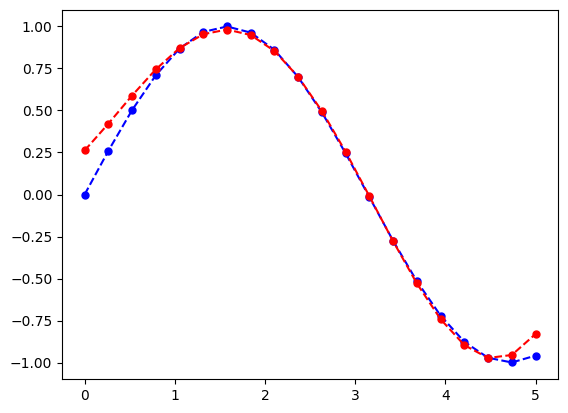

Generation: 1
Avg fitness: 109.51905891252436
Best fitness: 33.90876380129119
Generation: 2
Avg fitness: 50.50325773545441
Best fitness: 30.955953353344935
Generation: 3
Avg fitness: 43.40802840952587
Best fitness: 26.574067191627048
Generation: 4
Avg fitness: 41.34483508928927
Best fitness: 25.605931660016505
Generation: 5
Avg fitness: 36.76685975110193
Best fitness: 23.169247215910733
Generation: 6
Avg fitness: 32.91984415487159
Best fitness: 21.282285603579854
Generation: 7
Avg fitness: 42.56847013350713
Best fitness: 18.92687801516415
Generation: 8
Avg fitness: 35.17753099534032
Best fitness: 18.92687801516415
Generation: 9
Avg fitness: 34.22829763001574
Best fitness: 18.92687801516415
Generation: 10
Avg fitness: 34.39518198580852
Best fitness: 18.92687801516415
Generation: 11
Avg fitness: 35.29428840231289
Best fitness: 18.92687801516415
Generation: 12
Avg fitness: 34.594319963102684
Best fitness: 18.92687801516415
Generation: 13
Avg fitness: 36.759786754897256
Best fitness: 18.92

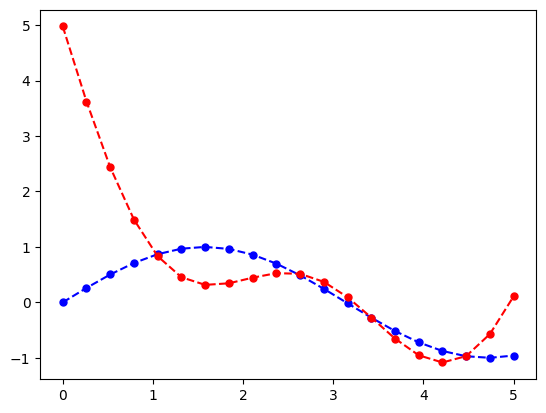

Generation: 1
Avg fitness: 128.55862574735093
Best fitness: 42.39268802630568
Generation: 2
Avg fitness: 57.58309030513521
Best fitness: 29.762068141378755
Generation: 3
Avg fitness: 55.25479718522257
Best fitness: 28.67306146062522
Generation: 4
Avg fitness: 45.360054393724425
Best fitness: 26.344100233761623
Generation: 5
Avg fitness: 37.74380519607016
Best fitness: 20.9504148814823
Generation: 6
Avg fitness: 35.55955180316201
Best fitness: 20.43370388527163
Generation: 7
Avg fitness: 34.673467510496245
Best fitness: 20.417338338991318
Generation: 8
Avg fitness: 34.59040121526413
Best fitness: 19.66854436283733
Generation: 9
Avg fitness: 34.475772842572944
Best fitness: 19.66854436283733
Generation: 10
Avg fitness: 34.99904749012142
Best fitness: 19.66854436283733
Generation: 11
Avg fitness: 39.78444293711858
Best fitness: 19.604135123001804
Generation: 12
Avg fitness: 36.54099619837596
Best fitness: 19.35780735303705
Generation: 13
Avg fitness: 39.10461270030969
Best fitness: 19.338

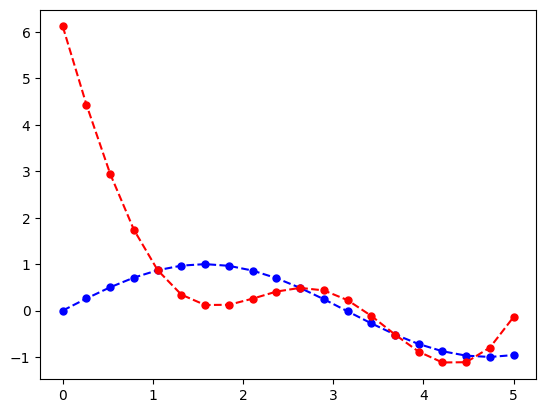

Generation: 1
Avg fitness: 82.03001617631914
Best fitness: 48.11886069811755
Generation: 2
Avg fitness: 60.72161020750933
Best fitness: 47.27355740399507
Generation: 3
Avg fitness: 81.68692967548046
Best fitness: 47.27355740399507
Generation: 4
Avg fitness: 64.1588351270522
Best fitness: 46.55817915475332
Generation: 5
Avg fitness: 71.33707851630177
Best fitness: 45.07955324399009
Generation: 6
Avg fitness: 68.7489602257578
Best fitness: 45.07955324399009
Generation: 7
Avg fitness: 73.45704207508976
Best fitness: 44.92582645753655
Generation: 8
Avg fitness: 71.24911922736518
Best fitness: 43.91860270802106
Generation: 9
Avg fitness: 67.99197550289469
Best fitness: 41.95284195092903
Generation: 10
Avg fitness: 66.3964618363926
Best fitness: 41.05561501000143
Generation: 11
Avg fitness: 66.68905450642222
Best fitness: 36.11190014240694
Generation: 12
Avg fitness: 54.7752036136663
Best fitness: 32.79767358754267
Generation: 13
Avg fitness: 67.73839556229527
Best fitness: 32.79767358754267

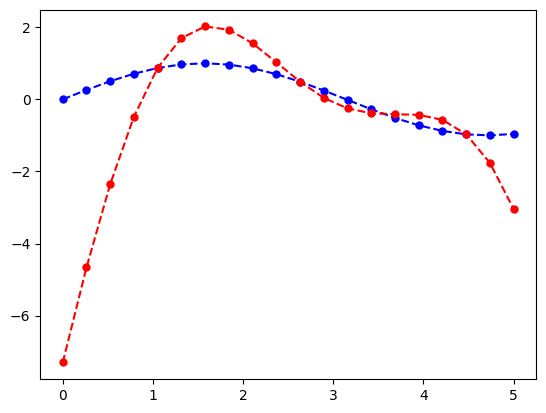

Generation: 1
Avg fitness: 45.88620273433833
Best fitness: 20.595250758037274
Generation: 2
Avg fitness: 28.383159763507834
Best fitness: 18.663672936769277
Generation: 3
Avg fitness: 26.91887178763602
Best fitness: 16.224537161960537
Generation: 4
Avg fitness: 23.77287917933747
Best fitness: 15.52910959626766
Generation: 5
Avg fitness: 24.415261175323295
Best fitness: 15.220667459569132
Generation: 6
Avg fitness: 25.549774383272865
Best fitness: 15.047975394855756
Generation: 7
Avg fitness: 25.31134027732817
Best fitness: 14.144834204198693
Generation: 8
Avg fitness: 25.862297289332744
Best fitness: 13.735623454719821
Generation: 9
Avg fitness: 20.485078954651158
Best fitness: 13.735623454719821
Generation: 10
Avg fitness: 22.60314577685538
Best fitness: 13.42488917824517
Generation: 11
Avg fitness: 22.066638688875738
Best fitness: 13.42488917824517
Generation: 12
Avg fitness: 21.901638142837307
Best fitness: 13.42488917824517
Generation: 13
Avg fitness: 24.63356962133261
Best fitness

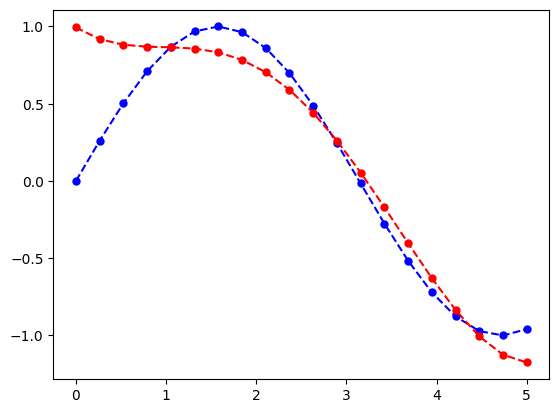

Generation: 1
Avg fitness: 189.93069596081102
Best fitness: 36.469709032839276
Generation: 2
Avg fitness: 75.9944398593515
Best fitness: 35.27299818693941
Generation: 3
Avg fitness: 62.71697001266295
Best fitness: 35.10201644928748
Generation: 4
Avg fitness: 54.619847694453
Best fitness: 35.10201644928748
Generation: 5
Avg fitness: 48.67158591501957
Best fitness: 33.100163444328125
Generation: 6
Avg fitness: 46.447130989596424
Best fitness: 30.627957066841237
Generation: 7
Avg fitness: 44.331849669019086
Best fitness: 30.619862408869754
Generation: 8
Avg fitness: 43.93277193950904
Best fitness: 28.92827080391989
Generation: 9
Avg fitness: 40.000814578686196
Best fitness: 23.207406956086114
Generation: 10
Avg fitness: 31.880092890191094
Best fitness: 23.047846922017005
Generation: 11
Avg fitness: 36.233522724493035
Best fitness: 19.197281536708633
Generation: 12
Avg fitness: 41.84731505436967
Best fitness: 17.18965647406444
Generation: 13
Avg fitness: 32.71930216371736
Best fitness: 17.

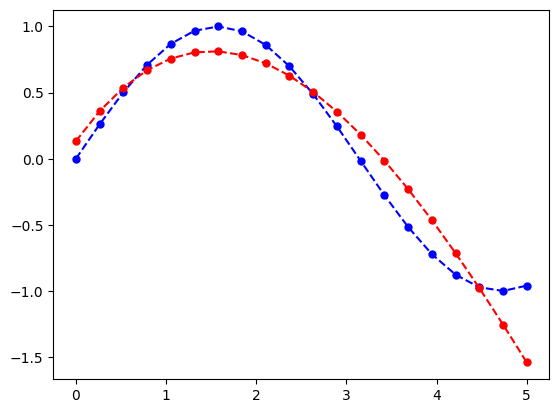

Generation: 1
Avg fitness: 121.89711794460788
Best fitness: 38.43522825829996
Generation: 2
Avg fitness: 53.754290904036594
Best fitness: 31.9194516849723
Generation: 3
Avg fitness: 58.32405726502198
Best fitness: 29.9560000415557
Generation: 4
Avg fitness: 44.79379228646775
Best fitness: 29.22725733172774
Generation: 5
Avg fitness: 47.71691108300456
Best fitness: 29.22725733172774
Generation: 6
Avg fitness: 52.32880305670582
Best fitness: 26.341004689691662
Generation: 7
Avg fitness: 40.861509189809084
Best fitness: 26.29883774791646
Generation: 8
Avg fitness: 38.20726388532357
Best fitness: 24.99478388191125
Generation: 9
Avg fitness: 41.99679378225275
Best fitness: 24.918653829667367
Generation: 10
Avg fitness: 45.87329121152578
Best fitness: 24.918653829667367
Generation: 11
Avg fitness: 44.26872377338962
Best fitness: 24.8888252148815
Generation: 12
Avg fitness: 41.9496047554093
Best fitness: 24.8888252148815
Generation: 13
Avg fitness: 39.48189853095239
Best fitness: 24.588869082

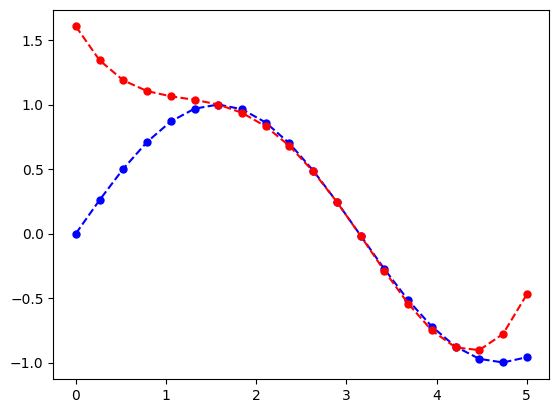

Generation: 1
Avg fitness: 116.4799033804134
Best fitness: 37.90814485203137
Generation: 2
Avg fitness: 96.1356862291644
Best fitness: 20.70823184589107
Generation: 3
Avg fitness: 44.672815619426565
Best fitness: 9.0272913730982
Generation: 4
Avg fitness: 37.84458264765001
Best fitness: 7.350743313499126
Generation: 5
Avg fitness: 13.829877490983284
Best fitness: 5.763528365450393
Generation: 6
Avg fitness: 12.171625603299018
Best fitness: 5.763528365450393
Generation: 7
Avg fitness: 10.496541560656341
Best fitness: 5.763528365450393
Generation: 8
Avg fitness: 8.341263438981976
Best fitness: 4.423840701665116
Generation: 9
Avg fitness: 9.94480576642788
Best fitness: 4.423840701665116
Generation: 10
Avg fitness: 8.812131584783081
Best fitness: 4.41024559923234
Generation: 11
Avg fitness: 9.76439227402106
Best fitness: 4.3777131594870085
Generation: 12
Avg fitness: 10.725244704713605
Best fitness: 4.200998495240341
Generation: 13
Avg fitness: 11.067570140960088
Best fitness: 4.2009984952

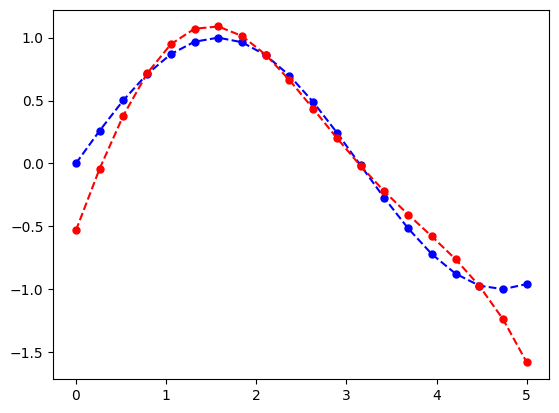

Generation: 1
Avg fitness: 149.61399801578918
Best fitness: 35.63339773212078
Generation: 2
Avg fitness: 114.9368672335677
Best fitness: 30.18582892814477
Generation: 3
Avg fitness: 40.97551611344517
Best fitness: 17.34092577404646
Generation: 4
Avg fitness: 32.53022755088784
Best fitness: 16.545949197024203
Generation: 5
Avg fitness: 29.637280717945913
Best fitness: 14.125195121075642
Generation: 6
Avg fitness: 25.868740159016646
Best fitness: 12.93136274253747
Generation: 7
Avg fitness: 21.706846653755044
Best fitness: 12.93136274253747
Generation: 8
Avg fitness: 24.877570017257103
Best fitness: 10.692660803629225
Generation: 9
Avg fitness: 23.019197098215542
Best fitness: 10.692660803629225
Generation: 10
Avg fitness: 25.22713609313969
Best fitness: 10.692660803629225
Generation: 11
Avg fitness: 18.979186300973463
Best fitness: 10.284488993017808
Generation: 12
Avg fitness: 24.75621561466517
Best fitness: 10.284488993017808
Generation: 13
Avg fitness: 30.724117904682522
Best fitness

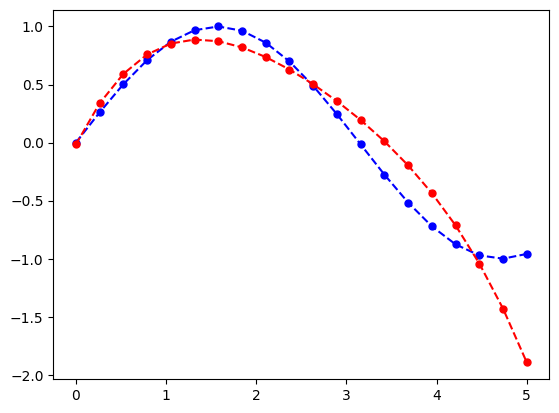

Generation: 1
Avg fitness: 104.69355089576666
Best fitness: 61.859922696603945
Generation: 2
Avg fitness: 81.85961518939372
Best fitness: 50.721067613660516
Generation: 3
Avg fitness: 63.27073036201218
Best fitness: 50.67425847155727
Generation: 4
Avg fitness: 62.18518376723382
Best fitness: 50.67425847155727
Generation: 5
Avg fitness: 68.07697833711356
Best fitness: 33.87906217079673
Generation: 6
Avg fitness: 59.6507730467108
Best fitness: 33.87871088601607
Generation: 7
Avg fitness: 55.962593414968495
Best fitness: 25.930194172469186
Generation: 8
Avg fitness: 50.47161126159017
Best fitness: 24.20504115239428
Generation: 9
Avg fitness: 50.760033561312355
Best fitness: 24.20504115239428
Generation: 10
Avg fitness: 40.49051146579346
Best fitness: 23.097747588094386
Generation: 11
Avg fitness: 44.97636743073693
Best fitness: 22.556062681216204
Generation: 12
Avg fitness: 44.06691907930937
Best fitness: 22.556062681216204
Generation: 13
Avg fitness: 33.96476881036266
Best fitness: 20.73

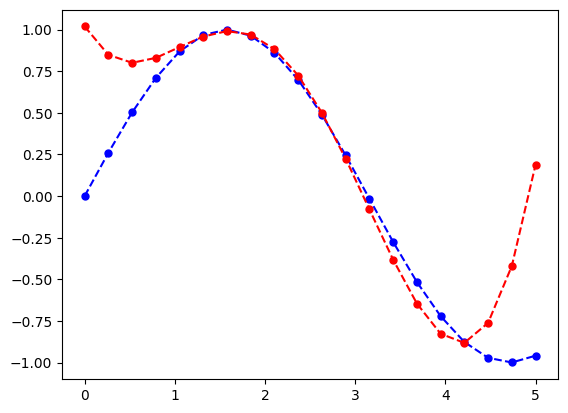

Generation: 1
Avg fitness: 125.1869358122639
Best fitness: 36.61013041052025
Generation: 2
Avg fitness: 43.10785268690146
Best fitness: 27.772751192887636
Generation: 3
Avg fitness: 40.464406834054216
Best fitness: 6.594122928072105
Generation: 4
Avg fitness: 23.510751785968004
Best fitness: 4.973618214612978
Generation: 5
Avg fitness: 12.232196957287384
Best fitness: 4.7072053406857695
Generation: 6
Avg fitness: 9.241705255726476
Best fitness: 4.7072053406857695
Generation: 7
Avg fitness: 8.677180970112007
Best fitness: 4.707205340685769
Generation: 8
Avg fitness: 9.582081573673854
Best fitness: 4.7072053406857695
Generation: 9
Avg fitness: 8.804671259071709
Best fitness: 4.7072053406857695
Generation: 10
Avg fitness: 9.696100491150316
Best fitness: 4.707205340685769
Generation: 11
Avg fitness: 9.326306192926223
Best fitness: 4.7072053406857695
Generation: 12
Avg fitness: 9.475834530785162
Best fitness: 4.7072053406857695
Generation: 13
Avg fitness: 7.867780907928777
Best fitness: 4.7

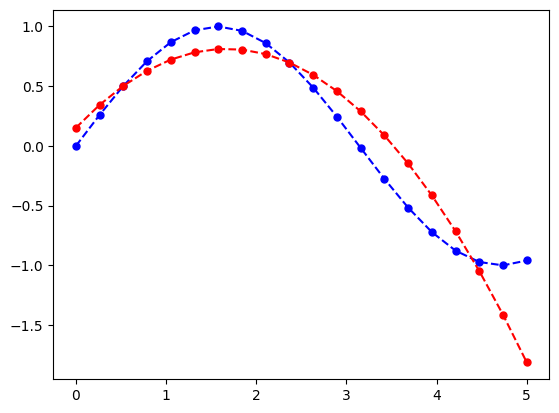

Generation: 1
Avg fitness: 150.37694066275498
Best fitness: 57.92356910726949
Generation: 2
Avg fitness: 71.18296235577928
Best fitness: 54.95640502774293
Generation: 3
Avg fitness: 68.14402995812753
Best fitness: 53.06396976166221
Generation: 4
Avg fitness: 66.3127236365692
Best fitness: 48.265744255542955
Generation: 5
Avg fitness: 67.39479950871296
Best fitness: 42.26846502146239
Generation: 6
Avg fitness: 53.098283908909735
Best fitness: 42.11274185194017
Generation: 7
Avg fitness: 59.36580479252285
Best fitness: 42.027347456618
Generation: 8
Avg fitness: 52.59353578661417
Best fitness: 35.721467124203116
Generation: 9
Avg fitness: 55.316769455367094
Best fitness: 35.721467124203116
Generation: 10
Avg fitness: 47.5486611889153
Best fitness: 35.55619266576988
Generation: 11
Avg fitness: 46.72197976905048
Best fitness: 34.786308596619286
Generation: 12
Avg fitness: 42.08877045887351
Best fitness: 32.03372116945149
Generation: 13
Avg fitness: 43.2721846154914
Best fitness: 32.03372116

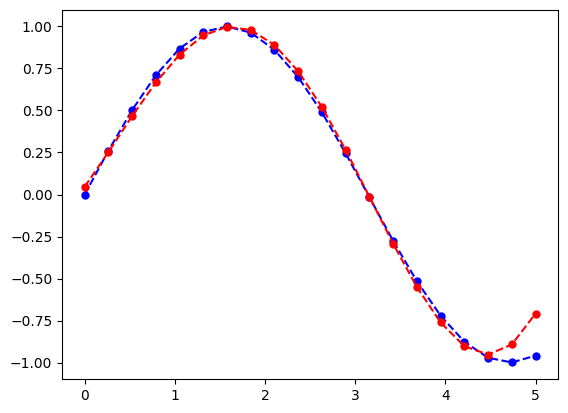

Generation: 1
Avg fitness: 171.6373116281469
Best fitness: 42.755985680358066
Generation: 2
Avg fitness: 152.32434731723805
Best fitness: 39.645422631011215
Generation: 3
Avg fitness: 51.29115490871313
Best fitness: 32.20367848782525
Generation: 4
Avg fitness: 44.95149977389929
Best fitness: 25.957566682597204
Generation: 5
Avg fitness: 41.910883994439274
Best fitness: 24.579414857280902
Generation: 6
Avg fitness: 38.49201108037276
Best fitness: 24.579414857280902
Generation: 7
Avg fitness: 38.475401950045
Best fitness: 18.058463850544015
Generation: 8
Avg fitness: 25.869586854124396
Best fitness: 15.472492719118133
Generation: 9
Avg fitness: 29.50306897700134
Best fitness: 15.441927203110161
Generation: 10
Avg fitness: 25.106470675069744
Best fitness: 13.147524410635183
Generation: 11
Avg fitness: 24.36860466596892
Best fitness: 12.460005503125597
Generation: 12
Avg fitness: 22.234613007245553
Best fitness: 12.015399793972467
Generation: 13
Avg fitness: 23.015440728582035
Best fitness

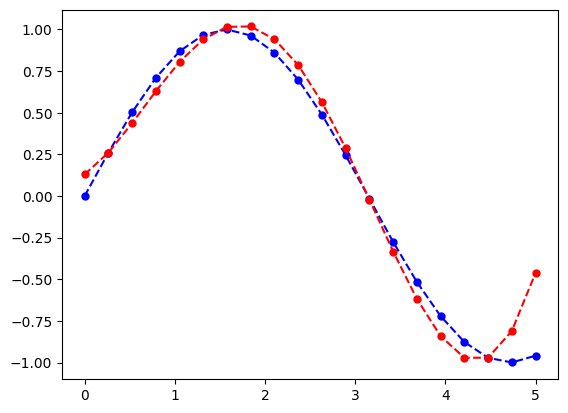

Generation: 1
Avg fitness: 102.64316920650316
Best fitness: 26.816579719774143
Generation: 2
Avg fitness: 41.391315517898775
Best fitness: 21.846666942931748
Generation: 3
Avg fitness: 27.45856792312828
Best fitness: 17.416387672234006
Generation: 4
Avg fitness: 26.31262541077849
Best fitness: 15.514670622216084
Generation: 5
Avg fitness: 24.19031174403437
Best fitness: 10.576755446453697
Generation: 6
Avg fitness: 18.749019886262566
Best fitness: 10.08156983713052
Generation: 7
Avg fitness: 19.272944252488966
Best fitness: 8.738609112018269
Generation: 8
Avg fitness: 17.056219207182913
Best fitness: 6.976288927720264
Generation: 9
Avg fitness: 18.378556934195615
Best fitness: 6.747599723483376
Generation: 10
Avg fitness: 17.002886250000817
Best fitness: 6.620718512292913
Generation: 11
Avg fitness: 15.949196175349485
Best fitness: 6.6155174772519185
Generation: 12
Avg fitness: 16.330009720021177
Best fitness: 6.6155174772519185
Generation: 13
Avg fitness: 16.06629532983699
Best fitnes

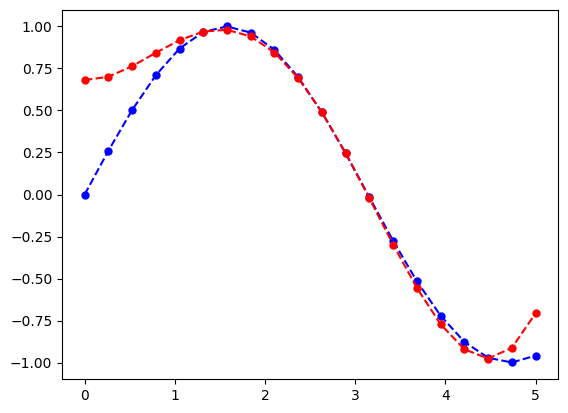

Generation: 1
Avg fitness: 172.08640786107455
Best fitness: 73.02778646497136
Generation: 2
Avg fitness: 128.87781980404452
Best fitness: 28.60656152107546
Generation: 3
Avg fitness: 44.479227332442655
Best fitness: 10.273117288484366
Generation: 4
Avg fitness: 17.36658362324467
Best fitness: 8.775935462916397
Generation: 5
Avg fitness: 10.69380588134588
Best fitness: 5.49524390854308
Generation: 6
Avg fitness: 9.100655738243546
Best fitness: 4.624396327430814
Generation: 7
Avg fitness: 8.351162924840047
Best fitness: 4.5737602502129775
Generation: 8
Avg fitness: 7.076379987710761
Best fitness: 4.3521733160199805
Generation: 9
Avg fitness: 7.86794998367599
Best fitness: 4.279473882794065
Generation: 10
Avg fitness: 8.022175446684368
Best fitness: 4.133907255382185
Generation: 11
Avg fitness: 8.047797422394655
Best fitness: 4.129406436661869
Generation: 12
Avg fitness: 6.905094797976847
Best fitness: 4.101153331447437
Generation: 13
Avg fitness: 9.22426405732307
Best fitness: 3.91451042

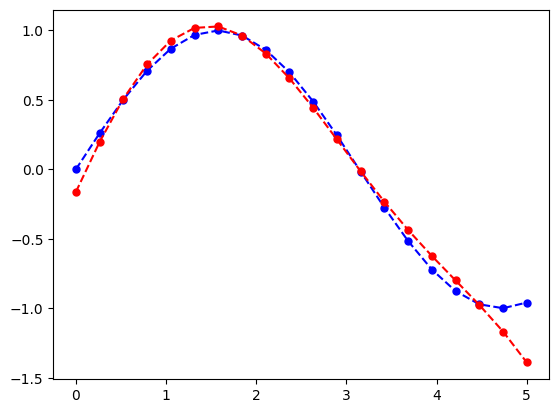

Generation: 1
Avg fitness: 108.07204729859443
Best fitness: 28.74518357823618
Generation: 2
Avg fitness: 40.47313028557924
Best fitness: 28.726029068353448
Generation: 3
Avg fitness: 40.123158640880334
Best fitness: 28.542610923295562
Generation: 4
Avg fitness: 36.341033401193016
Best fitness: 26.36748518613614
Generation: 5
Avg fitness: 39.010624134061636
Best fitness: 23.095366743758923
Generation: 6
Avg fitness: 35.2648059770493
Best fitness: 21.337397904890878
Generation: 7
Avg fitness: 33.11522375013963
Best fitness: 20.13587256326325
Generation: 8
Avg fitness: 26.62262468890002
Best fitness: 20.094475671279014
Generation: 9
Avg fitness: 30.960686129194624
Best fitness: 19.928755752044133
Generation: 10
Avg fitness: 29.839457935086326
Best fitness: 19.4100745483252
Generation: 11
Avg fitness: 30.70810474621526
Best fitness: 19.4100745483252
Generation: 12
Avg fitness: 31.893874459550297
Best fitness: 19.07877125827525
Generation: 13
Avg fitness: 37.21809783092641
Best fitness: 18.

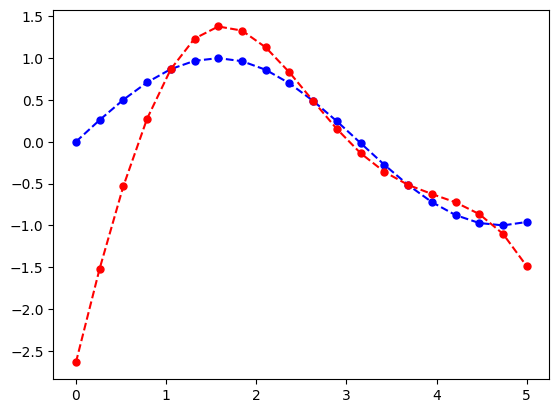

Generation: 1
Avg fitness: 63.64148936825836
Best fitness: 35.58161942681522
Generation: 2
Avg fitness: 52.89507150749846
Best fitness: 35.42986799290524
Generation: 3
Avg fitness: 55.31232200033809
Best fitness: 31.75900861459849
Generation: 4
Avg fitness: 46.91531386269292
Best fitness: 28.5318601566644
Generation: 5
Avg fitness: 52.475165813724814
Best fitness: 24.500338443116583
Generation: 6
Avg fitness: 42.481701970435
Best fitness: 24.001790247167204
Generation: 7
Avg fitness: 39.5956560885259
Best fitness: 22.218820826118694
Generation: 8
Avg fitness: 35.31675526654985
Best fitness: 22.1832882862166
Generation: 9
Avg fitness: 39.34843112453078
Best fitness: 21.671875471770694
Generation: 10
Avg fitness: 36.317524902226715
Best fitness: 19.548587609424445
Generation: 11
Avg fitness: 36.49198901272607
Best fitness: 19.09443377424724
Generation: 12
Avg fitness: 32.66412459140071
Best fitness: 18.985838114187587
Generation: 13
Avg fitness: 38.61646810876331
Best fitness: 18.9858381

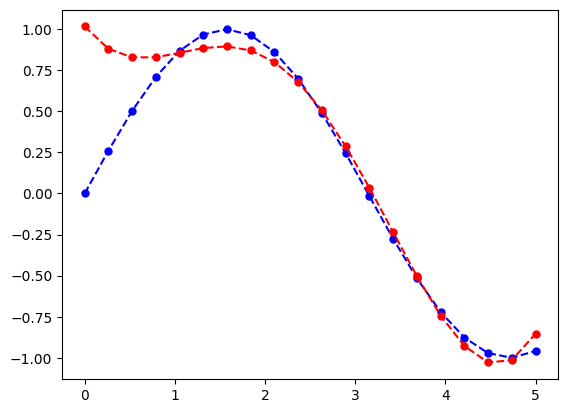

Avg best fitness: 7.74471727842663
Best: 0.37333723368037075


In [126]:
x = np.linspace(0, 5, 20)
y = np.sin(x)
population_l = 400
genome_l = 5
mutation_rate = .03

sum_best = 0
best = 10000000
count = 50
for i in range(count):
    population = Population(population_l, genome_l, mutation_rate, x, y)
    population.evolve_for_generations(1000)
    tmp = population.get_best_fitness()
    sum_best += tmp
    if(tmp < best):
        best = tmp
print("Avg best fitness:", sum_best/count)
print("Best:", best)

UNIFORM MUTATION

In [89]:
MULTIPLIER = 20
class Entity:
    def __init__(self, genome_len, xs, y, genome=None):
        self.genome_len = genome_len
        if genome is None:
            self.genome = [(random.random()-0.5)*MULTIPLIER for i in range(genome_len)]
        else:
            self.genome = genome
        self.xs = xs
        self.y = y
        self.phenotype = self.set_phenotype()
        self.fitness = self.set_fitness()
        self.probability = 0
        
    def __str__(self):
        # return f'Phenotype: {self.phenotype}, Genotype: {self.genome}, Fitness: {self.fitness}'
        return f'Genotype: {self.genome}, Fitness: {self.fitness}'
            
    def __lt__(self, other):
        if type(other) is Entity:
            return self.probability < other.probability
        return NotImplemented
    
    def set_phenotype(self):
        new_y = np.zeros(self.y.shape)
        for i in range(len(self.xs)):
            new_y += self.xs[i] * self.genome[i]
        new_y += np.sin(self.xs[1] * self.genome[self.genome_len - 2]) * self.genome[self.genome_len - 1]
        # print(new_y)
        return new_y
    
    def set_fitness(self):
        diff = np.absolute(self.y - self.phenotype)
        # print(diff)
        avg = np.sum(diff)
        # print(avg)
        return avg
    
    def set_probability(self, probability):
        self.probability = probability
        
    def show_graph(self):
        plt.plot(x, y, color='b', linestyle='--')
        plt.plot(x, y,'bo', markersize = 5)
        plt.plot(x, self.phenotype, color='r', linestyle='--')
        plt.plot(x, self.phenotype,'ro', markersize = 5)
        plt.show()
        
    @staticmethod
    def crossover(parent1, parent2):
        rnd = random.randint(0, parent1.genome_len - 1)
        new_genome = list()
        for i in range(rnd + 1):
            new_genome.append(parent1.genome[i])
        for i in range(rnd + 1, parent1.genome_len):
            new_genome.append(parent2.genome[i])
        return new_genome
    
    @staticmethod
    def mutation(genome, mutation_rate):
        # for i in range(len(genome)):
        #     if mutation_rate > random.random():
        #         genome[i] *= random.uniform(-2, 2)
        genome = list(np.array(genome) * np.random.normal(0,1))
        return genome
        

In [90]:
class Population:
    def __init__(self, population_len, genome_len, mutation_rate, x, y):
        self.population_len = population_len
        self.genome_len = genome_len
        self.mutation_rate = mutation_rate
        self.xs = [x**i for i in range(genome_len - 2)]
        self.y = y
        self.generation = -1
        self.entities = [Entity(genome_len, self.xs, self.y) for i in range(population_len)]
        self.define_population(self.entities)
    
    def define_population(self, entities):
        self.generation += 1
        self.entities = entities
        self.assign_probability()    
        self.entities.sort(reverse=True)
        # self.entities[0].show_graph()

    def __str__(self):
        strs = list()
        strs.append(f'Generation: {self.generation}')
        # strs.extend([str(self.entities[i]) for i in range(self.population_len)])
        # strs.append(f'Total fitness: {self.get_total_fitness()}')
        strs.append(f'Avg fitness: {self.get_avg_fitness()}')
        strs.append(f'Best fitness: {self.get_best_fitness()}')
        return '\n'.join(strs)
    
    def __iter__(self):
        self.current = -1
        return self
    
    def __next__(self):
        self.current += 1
        if self.current < self.population_len:
            return self.entities[self.current]
        raise StopIteration
    
    def __getitem__(self, item):
        return self.entities[item]
    
    def get_total_fitness(self):
        return sum(entity.fitness for entity in self.entities)
    
    def get_avg_fitness(self):
        return self.get_total_fitness()/self.population_len
        
    def get_best_fitness(self):
        return min(entity.fitness for entity in self.entities)
    
    def assign_probability(self):
        epsilon = 10**-9
        total_fitness = self.get_total_fitness()
        for entity in self.entities:
            # entity.set_probability((entity.get_fitness() + epsilon) / total_fitness)
            entity.set_probability(1 - (entity.fitness / total_fitness))
                
    def evolve(self):
        probabilities_list = [e.probability for e in self.entities]
        for i in range(1, self.population_len):
            probabilities_list[i] += probabilities_list[i - 1]
        new_entities = list()
        for i in range(self.population_len):
            p1, p2 = self.select_parents(probabilities_list)
            new_genome = Entity.crossover(self.entities[p1], self.entities[p2])
            new_genome = Entity.mutation(new_genome, self.mutation_rate)
            new_entities.append(Entity(self.genome_len, self.xs, self.y, new_genome))
        self.define_population(new_entities)
         
    def evolve_for_generations(self, generations):
        for i in range(generations):
            self.evolve()
            print(self)
        self.entities[0].show_graph()
            
    #If parent is already selected, 0.5p to select the left or right   
    @staticmethod
    def select_parents(probabilities_list):
        rnd = random.random()
        p1 = 0
        while probabilities_list[p1] < rnd:
            p1+=1
        rnd = random.random()
        p2 = 0
        while probabilities_list[p2] < rnd:
            p2+=1
        if p2 == p1:
            if p2 == len(probabilities_list) - 1:
                p2 -= 1
            elif p2 == 0:
              p2 += 1
            else:
                rnd = random.random()
                if rnd > 0.5:
                    p2 += 1
                else:
                    p2 -= 1
        return p1, p2

In [77]:
population_l = 400
genome_l = 5
mutation_rate = .03
population = Population(population_l, genome_l, mutation_rate, x, y)
print(population)

Generation: 0
Avg fitness: 3203.0937357528996
Best fitness: 111.51822374233029


Generation: 1
Avg fitness: 226.50297303088598
Best fitness: 10.596477987617249
Generation: 2
Avg fitness: 23.17263943636442
Best fitness: 9.63171674258312
Generation: 3
Avg fitness: 14.470878736783945
Best fitness: 9.538826257253929
Generation: 4
Avg fitness: 13.730973410049023
Best fitness: 9.508162308325275
Generation: 5
Avg fitness: 13.780540105977302
Best fitness: 9.474351346676409
Generation: 6
Avg fitness: 13.979850342038745
Best fitness: 9.471501099117246
Generation: 7
Avg fitness: 14.194749531342639
Best fitness: 9.469674185531371
Generation: 8
Avg fitness: 14.15980501915018
Best fitness: 9.466106760005488
Generation: 9
Avg fitness: 14.22951664785012
Best fitness: 9.465273894652515
Generation: 10
Avg fitness: 14.134334546771024
Best fitness: 9.465617238756794
Generation: 11
Avg fitness: 13.968463585480373
Best fitness: 9.464631088814127
Generation: 12
Avg fitness: 13.908788959719752
Best fitness: 9.466314604216059
Generation: 13
Avg fitness: 13.732794800475743
Best fitness: 9.4

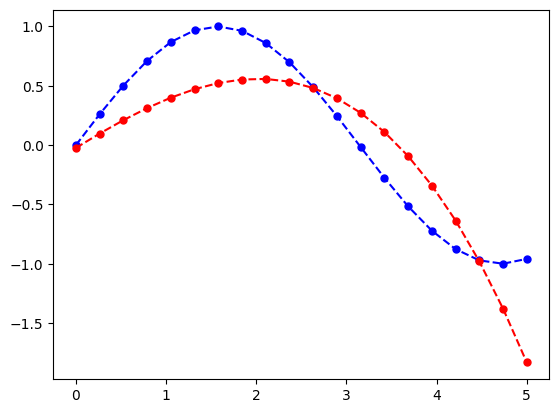

In [78]:
population.evolve_for_generations(1000)

In [ ]:
x = np.linspace(0, 5, 20)
y = np.sin(x)
population_l = 400
genome_l = 5
mutation_rate = .03

sum_best = 0
best = 10000000
count = 50
for i in range(count):
    population = Population(population_l, genome_l, mutation_rate, x, y)
    population.evolve_for_generations(1000)
    tmp = population.get_best_fitness()
    sum_best += tmp
    if(tmp < best):
        best = tmp
print("Avg best fitness:", sum_best/count)
print("Best:", best)

UNCORRELATED MUTATION WITH ONE STEP

In [128]:
import math
MULTIPLIER = 20
EPSILON = 0.05
class Entity:
    def __init__(self, genome_len, xs, y, genome=None):
        self.genome_len = genome_len
        if genome is None:
            self.genome = [(random.random()-0.5)*MULTIPLIER for i in range(genome_len)]
        else:
            self.genome = genome
        self.xs = xs
        self.y = y
        self.phenotype = self.set_phenotype()
        self.fitness = self.set_fitness()
        self.probability = 0
        
    def __str__(self):
        # return f'Phenotype: {self.phenotype}, Genotype: {self.genome}, Fitness: {self.fitness}'
        return f'Genotype: {self.genome}, Fitness: {self.fitness}'
            
    def __lt__(self, other):
        if type(other) is Entity:
            return self.probability < other.probability
        return NotImplemented
    
    def set_phenotype(self):
        new_y = np.zeros(self.y.shape)
        for i in range(len(self.xs)):
            new_y += self.xs[i] * self.genome[i]
        new_y += np.sin(self.xs[1] * self.genome[self.genome_len - 3]) * self.genome[self.genome_len - 2]
        # print(new_y)
        return new_y
    
    def set_fitness(self):
        diff = np.absolute(self.y - self.phenotype)
        # print(diff)
        avg = np.sum(diff)
        # print(avg)
        return avg
    
    def set_probability(self, probability):
        self.probability = probability
        
    def show_graph(self):
        plt.plot(x, y, color='b', linestyle='--')
        plt.plot(x, y,'bo', markersize = 5)
        plt.plot(x, self.phenotype, color='r', linestyle='--')
        plt.plot(x, self.phenotype,'ro', markersize = 5)
        plt.show()
        
    @staticmethod
    def crossover(parent1, parent2):
        rnd = random.randint(0, parent1.genome_len - 1)
        new_genome = list()
        for i in range(rnd + 1):
            new_genome.append(parent1.genome[i])
        for i in range(rnd + 1, parent1.genome_len):
            new_genome.append(parent2.genome[i])
        return new_genome
    
    @staticmethod
    def mutation(genome, tau):     
        sigma = genome[len(genome) - 1]
        sigma *= math.exp(np.random.normal(0, tau))
        if sigma < EPSILON:
            sigma = EPSILON
        genome[len(genome) - 1] = sigma
        # genome = list(np.array(genome) + np.random.normal(0,sigma, len(genome)))
        for i in range(len(genome) - 1):
            genome[i] *= np.random.normal(0, sigma)
        return genome
        

In [133]:
class Population:
    def __init__(self, population_len, genome_len, mutation_rate, x, y):
        self.population_len = population_len
        self.genome_len = genome_len
        self.mutation_rate = mutation_rate
        self.xs = [x**i for i in range(genome_len - 2)]
        self.y = y
        self.genome_len += 1
        self.generation = -1
        self.entities = [Entity(self.genome_len, self.xs, self.y) for i in range(population_len)]
        self.define_population(self.entities)
    
    def define_population(self, entities):
        self.generation += 1
        self.entities = entities
        self.assign_probability()    
        self.entities.sort(reverse=True)
        # self.entities[0].show_graph()

    def __str__(self):
        strs = list()
        strs.append(f'Generation: {self.generation}')
        # strs.extend([str(self.entities[i]) for i in range(self.population_len)])
        # strs.append(f'Total fitness: {self.get_total_fitness()}')
        strs.append(f'Avg fitness: {self.get_avg_fitness()}')
        strs.append(f'Best fitness: {self.get_best_fitness()}')
        return '\n'.join(strs)
    
    def __iter__(self):
        self.current = -1
        return self
    
    def __next__(self):
        self.current += 1
        if self.current < self.population_len:
            return self.entities[self.current]
        raise StopIteration
    
    def __getitem__(self, item):
        return self.entities[item]
    
    def get_total_fitness(self):
        return sum(entity.fitness for entity in self.entities)
    
    def get_avg_fitness(self):
        return self.get_total_fitness()/self.population_len
        
    def get_best_fitness(self):
        return min(entity.fitness for entity in self.entities)
    
    def assign_probability(self):
        epsilon = 10**-9
        total_fitness = self.get_total_fitness()
        for entity in self.entities:
            # entity.set_probability((entity.get_fitness() + epsilon) / total_fitness)
            entity.set_probability(1 - (entity.fitness / total_fitness))
                
    def evolve(self):
        probabilities_list = [e.probability for e in self.entities]
        for i in range(1, self.population_len):
            probabilities_list[i] += probabilities_list[i - 1]
        new_entities = list()
        for i in range(self.population_len):
            p1, p2 = self.select_parents(probabilities_list)
            new_genome = Entity.crossover(self.entities[p1], self.entities[p2])
            new_genome = Entity.mutation(new_genome, 1/math.sqrt(self.genome_len))
            new_entities.append(Entity(self.genome_len, self.xs, self.y, new_genome))
        self.define_population(new_entities)
         
    def evolve_for_generations(self, generations):
        for i in range(generations):
            self.evolve()
            print(self)
            print("Sigma", sum([e.genome[self.genome_len - 1] for e in self.entities])/self.population_len)
                
        self.entities[0].show_graph()
            
    #If parent is already selected, 0.5p to select the left or right   
    @staticmethod
    def select_parents(probabilities_list):
        rnd = random.random()
        p1 = 0
        while probabilities_list[p1] < rnd:
            p1+=1
        rnd = random.random()
        p2 = 0
        while probabilities_list[p2] < rnd:
            p2+=1
        if p2 == p1:
            if p2 == len(probabilities_list) - 1:
                p2 -= 1
            elif p2 == 0:
              p2 += 1
            else:
                rnd = random.random()
                if rnd > 0.5:
                    p2 += 1
                else:
                    p2 -= 1
        return p1, p2

In [134]:
population_l = 400
genome_l = 5
mutation_rate = .03
population = Population(population_l, genome_l, mutation_rate, x, y)
print(population)

Generation: 0
Avg fitness: 895.537631601593
Best fitness: 61.62189674642013


0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
1 0
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1
0 1


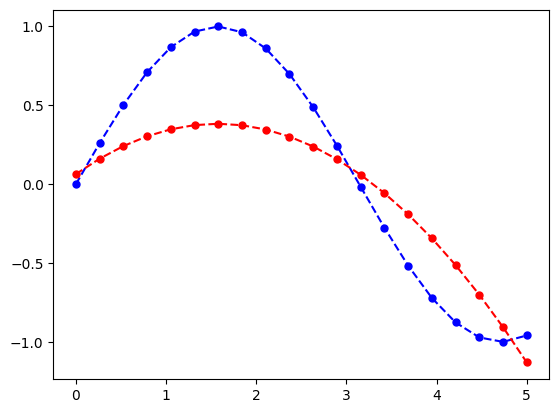

In [135]:
population.evolve_for_generations(1)

In [ ]:
x = np.linspace(0, 5, 20)
y = np.sin(x)
population_l = 400
genome_l = 5
mutation_rate = .03

sum_best = 0
best = 10000000
count = 50
for i in range(count):
    population = Population(population_l, genome_l, mutation_rate, x, y)
    population.evolve_for_generations(1000)
    tmp = population.get_best_fitness()
    sum_best += tmp
    if(tmp < best):
        best = tmp
print("Avg best fitness:", sum_best/count)
print("Best:", best)